# retrain rf model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from joblib import dump, load

ITEMS_NAME=["COAL", "COBBLESTONE", "CRAFTING_TABLE", "DIRT", "FURNACE", "IRON_AXE", "IRON_INGOT", "IRON_ORE", "IRON_PICKAXE", \
          "LOG", "PLANKS", "STICK", "STONE", "STONE_AXE", "STONE_PICKAXE", "TORCH", "WOODEN_AXE", "WOODEN_PICKAXE"] 

FEATURES_NAME=["inventory_firstGainOrder", "inventory_firstGainStep",\
            "inventory_accum_reward", "inventory_rewardedGainStep", "inventory_rewardedGainOrder",\
                     "if_iron_axe", "if_stone_axe", "if_wooden_axe", "sparse_reward", "dense_reward", \
            "attack_effi", "attack_ratio", "attack_equipped", "camera_mov_ratio", "position_mov_ratio", \
            "torch_placed", "cobblestone_placed", "dirt_placed", "stone_placed", "if_smelt_coal"]

def generate_0to5_names():
    names = []
    for i in range(5):
        for j in range(18):
            names.append(FEATURES_NAME[i]+"_"+str(j))
    return names

FEATURES_NAME_0to5=generate_0to5_names()

In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#ai_eva??
def prepare_Xy(df, test_size = 0.3):
    X=[]
    for fea in FEATURES_NAME:
        X.append(df[fea])
    X.append(df["ai_eva"])
    X.append(df["p1"])
    X.append(df["p2"])
    X.append(df["p3"])
    X=np.array(X).T
    y=np.array(df["m_eva"])
    
    X, y = sklearn.utils.shuffle(X, y) 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = test_size, random_state = 0)
    return X_train, X_test, y_train, y_test


def prepare_Xy_20(df):
    X=[]
    for fea in FEATURES_NAME:
        X.append(df[fea])
    X=np.array(X).T
    y=np.array(df["m_eva"])
    
    X, y = sklearn.utils.shuffle(X, y) 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
    return X_train, X_test, y_train, y_test


def k_fold(X_train, y_train, k=4, n=10, max_depth=10, n_estimators=10, min_samples_leaf=2, max_features="log2", store_model=False, print_res=False):
    kf = KFold(n_splits=k, shuffle=True, random_state=204)
    clf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=1, n_estimators=n_estimators)
    
    accs=[]
    train_accs=[]
    preds=[]
    gts=[]
    conf_mats=[]
    classes=[1,2,3]
    for i in range(n):
#         print("No : {}".format(i))
        for train, dev in kf.split(X_train, y_train):
            clf.fit(X_train[train], y_train[train])
            preds.append(clf.predict(X_train[dev]).tolist())
            gts.append(y_train[dev].tolist())
            conf_mat = confusion_matrix(y_train[dev], clf.predict(X_train[dev]))
            conf_mats.append(conf_mat)
            
            acc = clf.score(X_train[dev], y_train[dev])
            train_acc=clf.score(X_train[train], y_train[train])
            accs.append(acc)
            train_accs.append(train_acc)
#             print("gts:", gts, "preds:",preds)
#             print("acc : {}".format(acc))
#             print("feature_importances : {}".format(clf.feature_importances_)) 
            
    accs=np.array(accs)
    acc_ave=np.mean(accs)
    acc_std=np.std(accs)

    train_accs=np.array(train_accs)
    train_acc_ave=np.mean(train_accs)
    train_acc_std=np.std(train_accs)
    
    gts_array=np.array(sum(gts,[])) 
    preds_array=np.array(sum(preds,[]))
   
    confusion_mat = confusion_matrix(gts_array, preds_array)

    clf.fit(X_train, y_train)
    final_Acc=clf.score(X_train, y_train)
    
    if print_res:
        print("\ntest_acc_ave : {}, test_acc_std:{}".format(acc_ave, acc_std))
        print("\ntrain_acc_ave : {}, train_acc_std:{}".format(train_acc_ave, train_acc_std))
        print("final_Acc:", final_Acc)

        print(gts_array.shape, preds_array.shape)
        print("gts:", gts_array, "preds:",preds_array)
        print("confusion_mat : {}".format(confusion_mat))
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
        disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
        plt.show()

    if store_model:
        dump(clf, 'RF-2.model')
    
    return acc_ave, acc_std, clf, train_acc_ave, train_acc_std, final_Acc, confusion_mat
        
    
def final_test(clf, X_test, y_test):
    classes=[1,2,3]
    acc = clf.score(X_test, y_test)
    print("acc : {}".format(acc))
    print("feature_importances : {}".format(clf.feature_importances_)) 
    
    confusion_mat = confusion_matrix(y_test, clf.predict(X_test))
    print("confusion_mat : {}".format(confusion_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
    plt.show()
    
    return acc


In [3]:
df = pd.read_csv("./test-data/fea_m_all.csv")
df.attack_effi[df.attack_effi>0.05] = 0.05

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
def repeat_test(n=10, max_depth=5, n_estimators=10, min_samples_leaf=4):
    X_train, X_test, y_train, y_test=prepare_Xy(df)
    X=np.concatenate((X_train, X_test))
    y=np.concatenate((y_train, y_test))
    acc_aves=[]
    acc_stds=[]
    train_acc_aves=[]
    train_acc_stds=[]
    final_Accs=[]
    confusion_mats=[]
    
    for i in range(n): 
        if i%10==9:
            print("No : {}".format(i))
        acc_ave, acc_std, clf, train_acc_ave, train_acc_std, final_Acc, confusion_mat=k_fold(X, y, k=10, n=1, 
                             max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf) 
        acc_aves.append(acc_ave)
        acc_stds.append(acc_std)
        train_acc_aves.append(train_acc_ave)
        train_acc_stds.append(train_acc_std)
        final_Accs.append(final_Acc)
        confusion_mats.append(confusion_mat)
        
        X, y = sklearn.utils.shuffle(X, y) 
    acc_aves=np.array(acc_aves)
    acc_stds=np.array(acc_stds)
    train_acc_aves=np.array(train_acc_aves)
    train_acc_stds=np.array(train_acc_stds)
    final_Accs=np.array(final_Accs)
    confusion_mats=np.array(confusion_mats)
    print("\nacc_aves_ave : {:.4}, acc_aves_std : {:.4}, acc_stds_ave:{:.4}"
          .format(np.mean(acc_aves),np.std(acc_aves), np.mean(acc_stds)))
    print("train_acc_aves_ave : {:.4}, train_acc_aves_std : {:.4}, train_acc_stds_ave:{:.4}"
          .format(np.mean(train_acc_aves),np.std(train_acc_aves), np.mean(train_acc_stds)))
    print("final_Accs_ave : {:.4}, final_Accs_std : {:.4}"
          .format(np.mean(final_Accs),np.std(final_Accs)))
    confusion_mats_sum=np.sum(confusion_mats,axis=0)
    print(confusion_mats_sum)
    classes=[1,2,3]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mats_sum, display_labels=classes)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="horizontal", values_format="d")
    plt.show()
    
    return confusion_mats
    

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5535, acc_aves_std : 0.02362, acc_stds_ave:0.154
train_acc_aves_ave : 0.8413, train_acc_aves_std : 0.01005, train_acc_stds_ave:0.02527
final_Accs_ave : 0.8414, final_Accs_std : 0.02181
[[  31  415  204]
 [  25 1223  652]
 [   9  638 1153]]


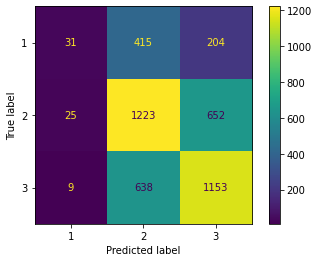

In [57]:
confusion_mats=repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

In [58]:
confusion_mats

array([[[ 2,  6,  5],
        [ 0, 24, 14],
        [ 0, 12, 24]],

       [[ 2,  7,  4],
        [ 0, 26, 12],
        [ 0, 11, 25]],

       [[ 0,  8,  5],
        [ 1, 23, 14],
        [ 0, 11, 25]],

       [[ 1,  7,  5],
        [ 1, 24, 13],
        [ 0, 11, 25]],

       [[ 1,  7,  5],
        [ 1, 23, 14],
        [ 0, 10, 26]],

       [[ 0,  9,  4],
        [ 2, 23, 13],
        [ 0, 14, 22]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 11, 25]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 14, 22]],

       [[ 1,  8,  4],
        [ 1, 22, 15],
        [ 1, 11, 24]],

       [[ 0,  9,  4],
        [ 0, 24, 14],
        [ 0, 12, 24]],

       [[ 1,  8,  4],
        [ 0, 22, 16],
        [ 0, 13, 23]],

       [[ 0,  9,  4],
        [ 2, 23, 13],
        [ 1, 10, 25]],

       [[ 1, 10,  2],
        [ 1, 26, 11],
        [ 0, 15, 21]],

       [[ 0,  8,  5],
        [ 0, 23, 15],
        [ 0, 11, 25]],

       [[ 1,  9,  3],
        [ 1, 26, 11],
    

In [60]:
marg_truths=np.sum(confusion_mats, axis=2)
marg_preds=np.sum(confusion_mats, axis=1)

print("truths",np.sum(marg_truths, axis=0))
print("preds",np.sum(marg_preds, axis=0))

truths [ 650 1900 1800]
preds [  65 2276 2009]


In [62]:
#marg_truths #[13, 38, 36] *50

In [64]:
np.std(marg_preds, axis=0)

array([0.9       , 3.16379519, 3.06391906])

In [65]:
np.mean(marg_preds, axis=0)

array([ 1.3 , 45.52, 40.18])

In [63]:
marg_preds

array([[ 2, 42, 43],
       [ 2, 44, 41],
       [ 1, 42, 44],
       [ 2, 42, 43],
       [ 2, 40, 45],
       [ 2, 46, 39],
       [ 0, 44, 43],
       [ 0, 47, 40],
       [ 3, 41, 43],
       [ 0, 45, 42],
       [ 1, 43, 43],
       [ 3, 42, 42],
       [ 2, 51, 34],
       [ 0, 42, 45],
       [ 2, 47, 38],
       [ 4, 45, 38],
       [ 1, 44, 42],
       [ 1, 50, 36],
       [ 2, 44, 41],
       [ 1, 45, 41],
       [ 2, 48, 37],
       [ 1, 44, 42],
       [ 1, 44, 42],
       [ 1, 46, 40],
       [ 1, 45, 41],
       [ 2, 47, 38],
       [ 0, 51, 36],
       [ 0, 49, 38],
       [ 1, 50, 36],
       [ 2, 47, 38],
       [ 2, 39, 46],
       [ 2, 40, 45],
       [ 0, 52, 35],
       [ 2, 45, 40],
       [ 1, 44, 42],
       [ 2, 46, 39],
       [ 1, 46, 40],
       [ 0, 45, 42],
       [ 0, 42, 45],
       [ 2, 51, 34],
       [ 1, 51, 35],
       [ 1, 46, 40],
       [ 1, 48, 38],
       [ 1, 50, 36],
       [ 1, 46, 40],
       [ 2, 47, 38],
       [ 1, 48, 38],
       [ 2, 4

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5244, acc_aves_std : 0.03727, acc_stds_ave:0.1583
train_acc_aves_ave : 0.8213, train_acc_aves_std : 0.0118, train_acc_stds_ave:0.02745
final_Accs_ave : 0.8191, final_Accs_std : 0.02619
[[  43  419  188]
 [  51 1160  689]
 [  21  701 1078]]


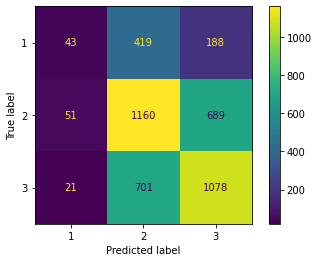

In [27]:
repeat_test(n=50, max_depth=5, n_estimators=20, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.535, acc_aves_std : 0.03477, acc_stds_ave:0.1558
train_acc_aves_ave : 0.8236, train_acc_aves_std : 0.01136, train_acc_stds_ave:0.028
final_Accs_ave : 0.8251, final_Accs_std : 0.02563
[[  45  402  203]
 [  42 1144  714]
 [  24  641 1135]]


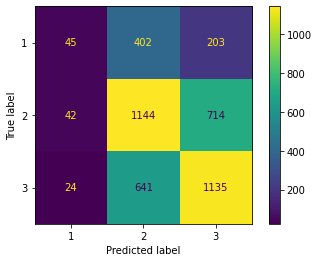

In [28]:
repeat_test(n=50, max_depth=10, n_estimators=20, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5449, acc_aves_std : 0.02744, acc_stds_ave:0.1582
train_acc_aves_ave : 0.8287, train_acc_aves_std : 0.01031, train_acc_stds_ave:0.02513
final_Accs_ave : 0.8179, final_Accs_std : 0.02111
[[  41  396  213]
 [  31 1177  692]
 [  11  640 1149]]


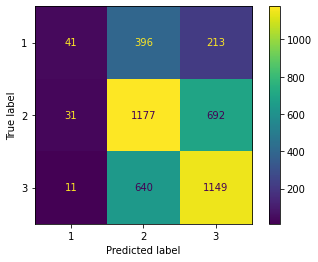

In [29]:
repeat_test(n=50, max_depth=5, n_estimators=30, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5479, acc_aves_std : 0.02703, acc_stds_ave:0.155
train_acc_aves_ave : 0.8278, train_acc_aves_std : 0.009348, train_acc_stds_ave:0.02582
final_Accs_ave : 0.8313, final_Accs_std : 0.01929
[[  34  420  196]
 [  29 1192  679]
 [  11  630 1159]]


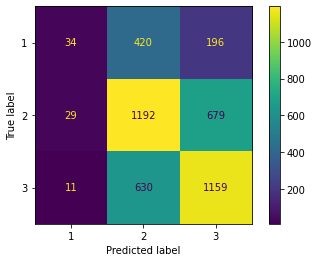

In [50]:
repeat_test(n=50, max_depth=5, n_estimators=30, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5424, acc_aves_std : 0.03279, acc_stds_ave:0.1637
train_acc_aves_ave : 0.8388, train_acc_aves_std : 0.009233, train_acc_stds_ave:0.024
final_Accs_ave : 0.8333, final_Accs_std : 0.02664
[[  26  425  199]
 [  30 1189  681]
 [   6  648 1146]]


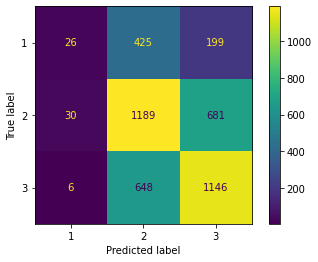

In [32]:
repeat_test(n=50, max_depth=5, n_estimators=40, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5498, acc_aves_std : 0.03214, acc_stds_ave:0.1554
train_acc_aves_ave : 0.8372, train_acc_aves_std : 0.01012, train_acc_stds_ave:0.02564
final_Accs_ave : 0.843, final_Accs_std : 0.02374
[[  36  412  202]
 [  34 1183  683]
 [  15  614 1171]]


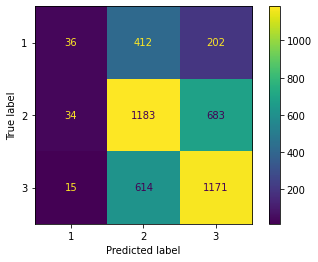

In [47]:
repeat_test(n=50, max_depth=5, n_estimators=40, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5541, acc_aves_std : 0.02933, acc_stds_ave:0.1596
train_acc_aves_ave : 0.8383, train_acc_aves_std : 0.009231, train_acc_stds_ave:0.0249
final_Accs_ave : 0.832, final_Accs_std : 0.0208
[[  33  401  216]
 [  22 1214  664]
 [  10  627 1163]]


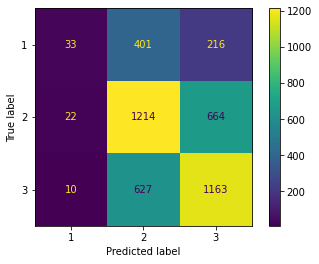

In [33]:
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5488, acc_aves_std : 0.02837, acc_stds_ave:0.1584
train_acc_aves_ave : 0.8407, train_acc_aves_std : 0.008353, train_acc_stds_ave:0.02424
final_Accs_ave : 0.8395, final_Accs_std : 0.0224
[[  22  426  202]
 [  24 1205  671]
 [   8  634 1158]]


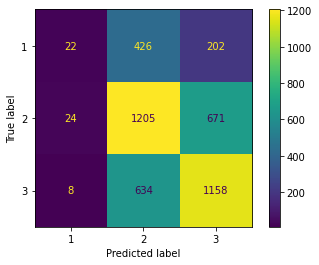

In [46]:
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5556, acc_aves_std : 0.03063, acc_stds_ave:0.1548
train_acc_aves_ave : 0.8479, train_acc_aves_std : 0.01044, train_acc_stds_ave:0.02399
final_Accs_ave : 0.8457, final_Accs_std : 0.02182
[[  25  410  215]
 [  29 1214  657]
 [   6  617 1177]]


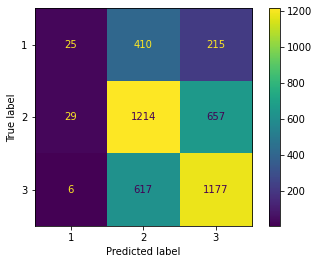

In [51]:
repeat_test(n=50, max_depth=10, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5503, acc_aves_std : 0.03094, acc_stds_ave:0.1605
train_acc_aves_ave : 0.8486, train_acc_aves_std : 0.0102, train_acc_stds_ave:0.02559
final_Accs_ave : 0.8513, final_Accs_std : 0.02074
[[  35  401  214]
 [  23 1214  663]
 [   5  650 1145]]


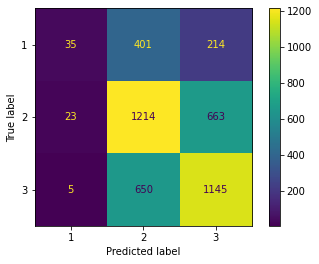

In [52]:
repeat_test(n=50, max_depth=10, n_estimators=50, min_samples_leaf=4)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5395, acc_aves_std : 0.0254, acc_stds_ave:0.1552
train_acc_aves_ave : 0.7997, train_acc_aves_std : 0.009794, train_acc_stds_ave:0.02797
final_Accs_ave : 0.7972, final_Accs_std : 0.02342
[[  10  430  210]
 [  22 1186  692]
 [   1  650 1149]]


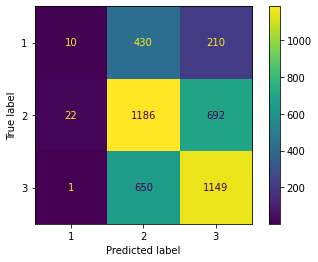

In [34]:
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=5)

No : 9
No : 19
No : 29
No : 39
No : 49

acc_aves_ave : 0.5356, acc_aves_std : 0.02948, acc_stds_ave:0.1567
train_acc_aves_ave : 0.762, train_acc_aves_std : 0.008475, train_acc_stds_ave:0.027
final_Accs_ave : 0.7664, final_Accs_std : 0.02327
[[   2  438  210]
 [  12 1199  689]
 [   1  670 1129]]


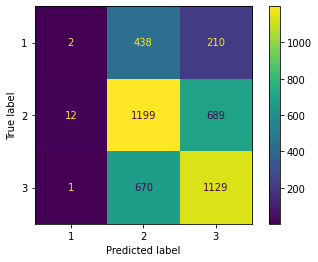

In [35]:
repeat_test(n=50, max_depth=5, n_estimators=50, min_samples_leaf=6)

In [4]:
X_train, X_test, y_train, y_test=prepare_Xy(df)

In [5]:
np.concatenate((X_train, X_test)).shape

(87, 24)

In [6]:
np.concatenate((y_train, y_test)).shape

(87,)

No : 0
acc : 0.7777777777777778
feature_importances : [0.02274029 0.01488709 0.04799627 0.01995999 0.         0.
 0.         0.         0.05933725 0.07054847 0.12904479 0.10939699
 0.03960586 0.06246612 0.11242068 0.09310418 0.01471558 0.04602275
 0.         0.         0.00190067 0.04351919 0.0539116  0.05842224]
acc : 0.5555555555555556
feature_importances : [0.00534759 0.03181823 0.04101022 0.0255323  0.02382652 0.
 0.         0.00059796 0.03289445 0.07117146 0.04216999 0.10046923
 0.08539551 0.05698563 0.07525037 0.09256782 0.08322192 0.05317299
 0.         0.         0.00680972 0.04634352 0.06434158 0.06107297]
acc : 0.7777777777777778
feature_importances : [0.00695876 0.01036071 0.01606432 0.01518486 0.01187968 0.
 0.         0.00813932 0.02230777 0.08959132 0.05544591 0.11695836
 0.0262683  0.03130202 0.0785493  0.08383159 0.04869085 0.09078871
 0.         0.         0.01353648 0.05873866 0.08195738 0.13344569]
acc : 0.6666666666666666
feature_importances : [0.02299456 0.        

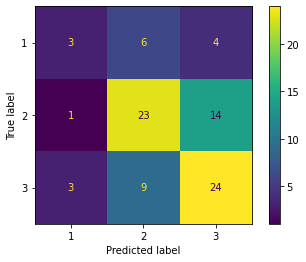

final_Acc: 0.8620689655172413


In [7]:
acc_ave, acc_std, clf=k_fold(np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), k=10, n=1)

No : 0
acc : 0.7777777777777778
feature_importances : [0.04074858 0.         0.01886995 0.         0.         0.
 0.         0.         0.0832575  0.0473703  0.01288793 0.06826925
 0.02292742 0.09856332 0.0633142  0.18400452 0.10315782 0.0570403
 0.         0.         0.         0.05244041 0.06279088 0.08435764]
acc : 0.6666666666666666
feature_importances : [0.01272494 0.         0.         0.         0.04249947 0.
 0.         0.         0.02840109 0.09276415 0.05515323 0.09603053
 0.05053706 0.03549632 0.05675605 0.1402618  0.0217885  0.07982972
 0.         0.         0.04047959 0.06553629 0.04839924 0.13334202]
acc : 0.5555555555555556
feature_importances : [0.02599473 0.         0.         0.         0.0425356  0.
 0.         0.         0.         0.12897209 0.04414938 0.09780186
 0.0338724  0.03499238 0.23754959 0.0417378  0.01751262 0.06718283
 0.         0.         0.         0.02369726 0.10482665 0.09917483]
acc : 0.5555555555555556
feature_importances : [0.026623   0.         

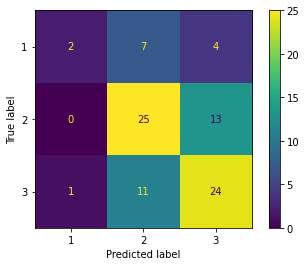

final_Acc: 0.7931034482758621


In [43]:
acc_ave, acc_std, clf=k_fold(np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), k=10, n=1, 
                             max_depth=5, n_estimators=5, min_samples_leaf=4)



### Train-Test 7:3, 4 folds

No : 0
acc : 0.5333333333333333
feature_importances : [0.01044793 0.         0.02313554 0.00813357 0.         0.
 0.00174369 0.         0.06590504 0.10353528 0.04094318 0.11012771
 0.03903538 0.05484345 0.11513659 0.04341635 0.06277767 0.10237758
 0.         0.         0.00655369 0.05099381 0.07504381 0.08584973]
acc : 0.6
feature_importances : [0.02831474 0.0003     0.00728259 0.01522965 0.02215318 0.
 0.         0.01152425 0.05815962 0.06339073 0.04157163 0.11922584
 0.08133883 0.0834935  0.05032795 0.03236964 0.1193361  0.09730788
 0.         0.         0.00046338 0.03528216 0.04835987 0.08456847]
acc : 0.4
feature_importances : [0.00566356 0.00740226 0.01125501 0.00698321 0.00404624 0.
 0.00305577 0.         0.0685836  0.07421311 0.05305162 0.16415783
 0.07824941 0.07720094 0.08276271 0.04753263 0.08731327 0.08702056
 0.         0.         0.01250958 0.05517016 0.04160618 0.03222233]
acc : 0.4666666666666667
feature_importances : [0.00967992 0.00745733 0.02535656 0.01236843 0.00121

acc : 0.4
feature_importances : [0.00566356 0.00740226 0.01125501 0.00698321 0.00404624 0.
 0.00305577 0.         0.0685836  0.07421311 0.05305162 0.16415783
 0.07824941 0.07720094 0.08276271 0.04753263 0.08731327 0.08702056
 0.         0.         0.01250958 0.05517016 0.04160618 0.03222233]
acc : 0.4666666666666667
feature_importances : [0.00967992 0.00745733 0.02535656 0.01236843 0.00121172 0.
 0.00687184 0.00163755 0.03693927 0.0536372  0.07602624 0.09880759
 0.05210202 0.04866222 0.19265643 0.02700367 0.06629917 0.13035741
 0.         0.         0.01249217 0.0541702  0.05173578 0.03452728]
No : 8
acc : 0.5333333333333333
feature_importances : [0.01044793 0.         0.02313554 0.00813357 0.         0.
 0.00174369 0.         0.06590504 0.10353528 0.04094318 0.11012771
 0.03903538 0.05484345 0.11513659 0.04341635 0.06277767 0.10237758
 0.         0.         0.00655369 0.05099381 0.07504381 0.08584973]
acc : 0.6
feature_importances : [0.02831474 0.0003     0.00728259 0.01522965 0.02215

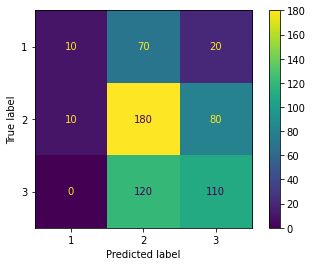

In [31]:
acc_ave, clf=k_fold(X_train, y_train, k=4, n=10, max_depth=10, n_estimators=20)

acc : 0.5555555555555556
feature_importances : [0.00580261 0.01725939 0.0272632  0.01472947 0.00270593 0.
 0.00052062 0.00582052 0.0439753  0.05303102 0.06271611 0.0876853
 0.04525374 0.09323244 0.0984736  0.07161378 0.07949895 0.09721938
 0.         0.         0.01793952 0.04135427 0.0620407  0.07186415]
confusion_mat : [[1 0 2]
 [1 7 3]
 [0 6 7]]


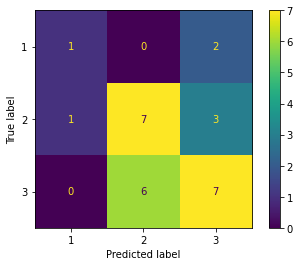

In [27]:
clf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, max_features="log2", random_state=1, n_estimators=30)
clf.fit(X_train, y_train)
final_acc=final_test(clf, X_test, y_test)

In [34]:
def predict_rf2(df):
    clf = load('./models/RF-2.model')
    X=[]
    for fea in FEATURES_NAME:
        X.append(df[fea])
    X.append(df["ai_eva"])
    X.append(df["p1"])
    X.append(df["p2"])
    X.append(df["p3"])
    X=np.array(X).T
    y=np.array(df["m_eva"])
    
    prediction = clf.predict(X)
    pred_prob=clf.predict_proba(X)
    
    df.insert(df.shape[1], "ai2_eva", prediction)
    df.insert(df.shape[1], "ai2_p1", pred_prob[:,0])
    df.insert(df.shape[1], "ai2_p2", pred_prob[:,1])
    df.insert(df.shape[1], "ai2_p3", pred_prob[:,2])
    
    df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)
 
    return prediction, pred_prob



In [35]:
prediction, pred_prob=predict_rf2(df)
print(prediction.shape)
print(pred_prob.shape)

(87,)
(87, 3)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  

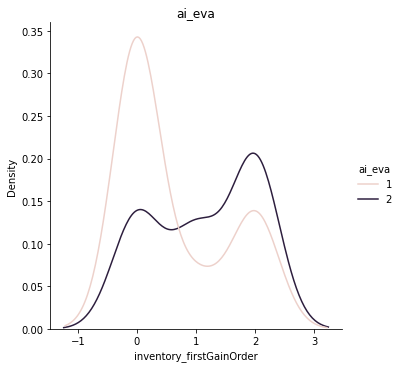

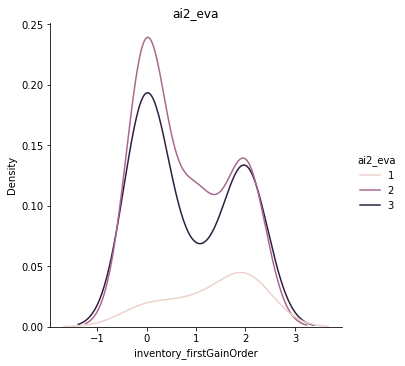

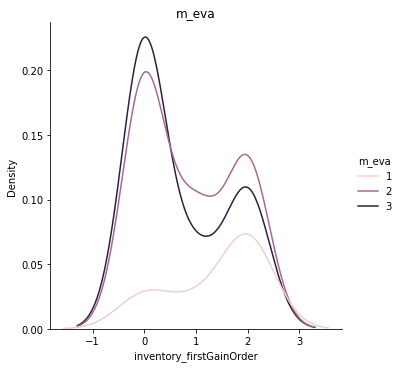

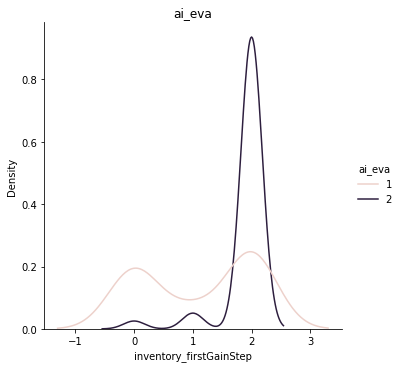

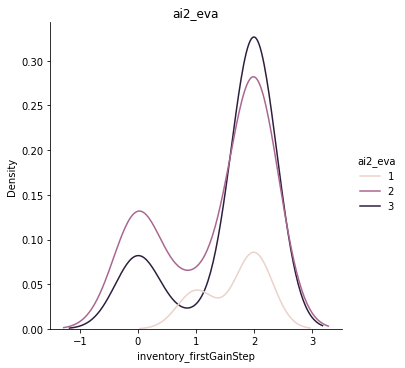

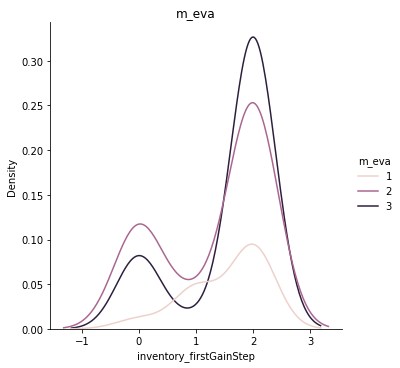

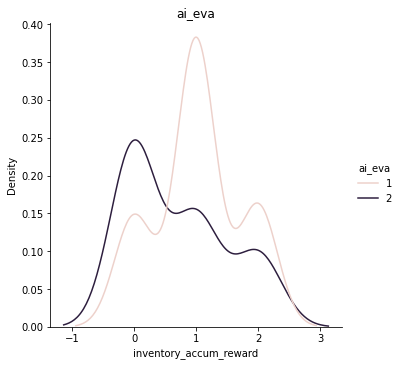

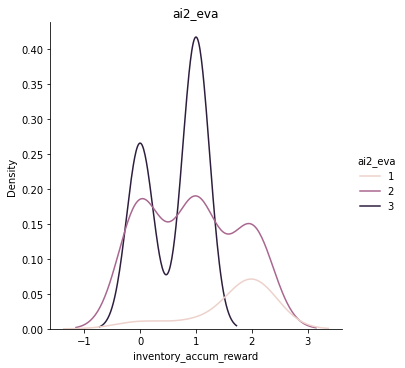

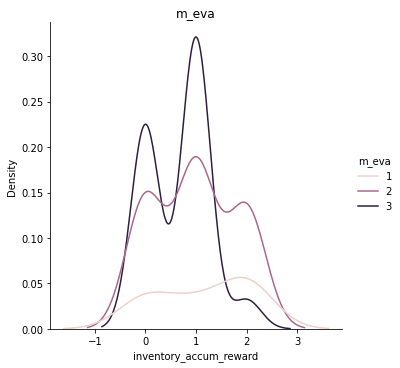

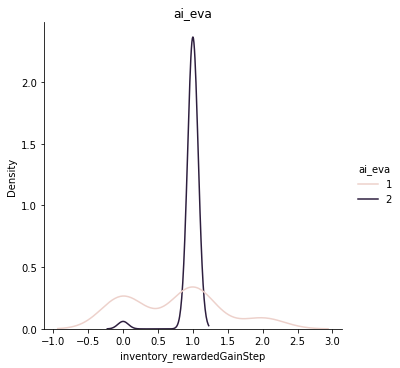

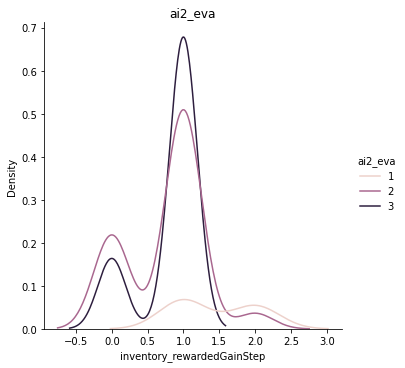

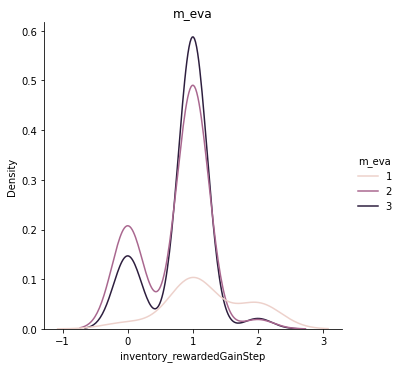

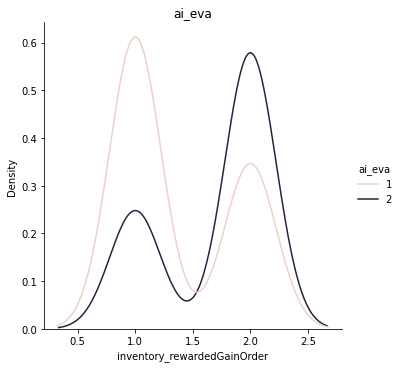

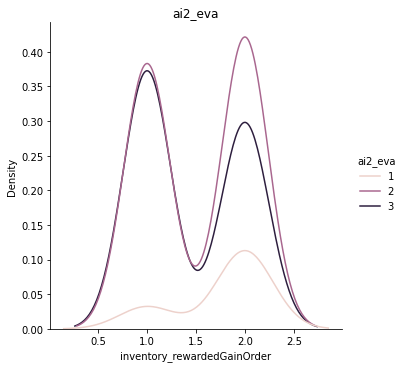

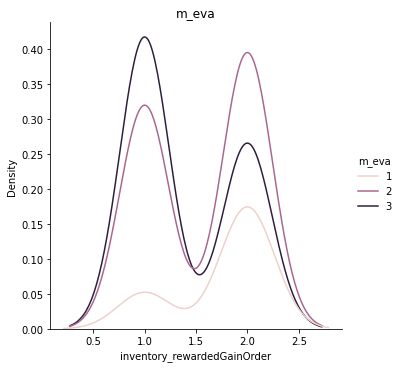

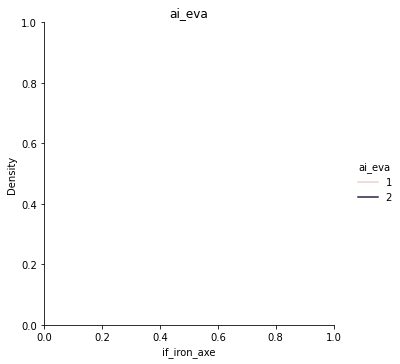

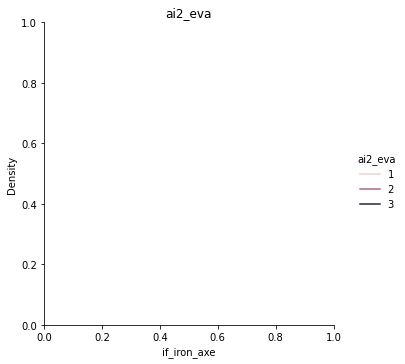

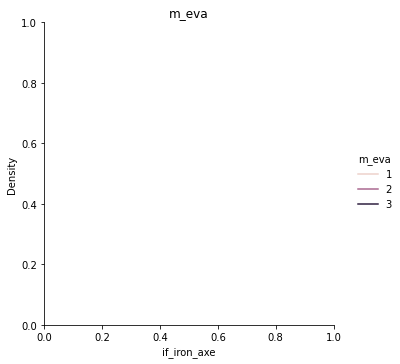

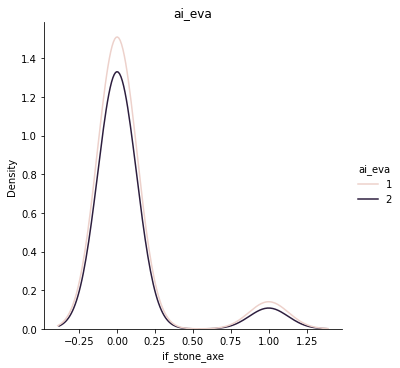

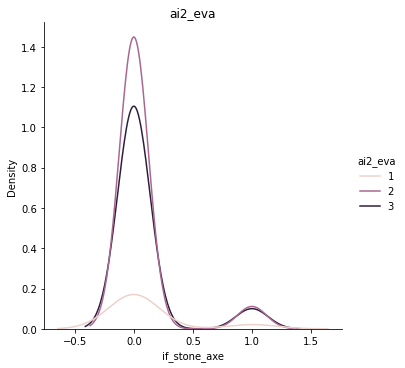

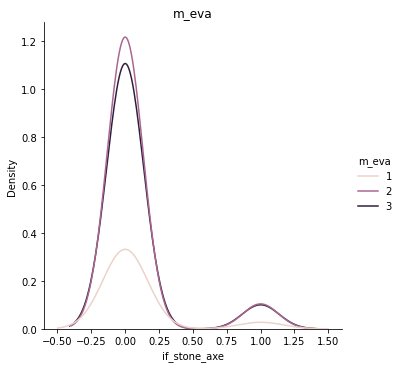

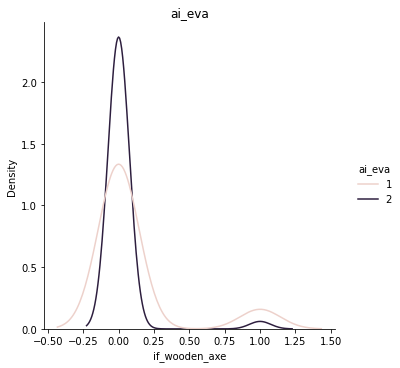

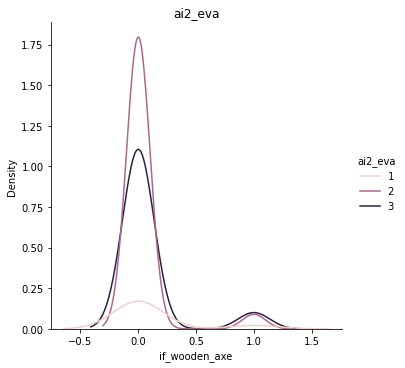

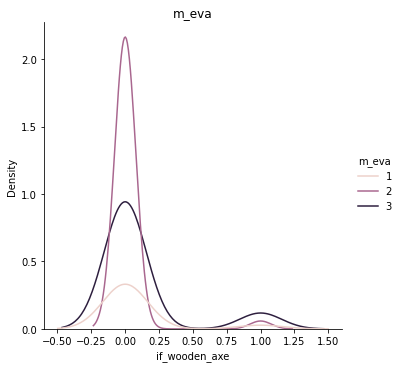

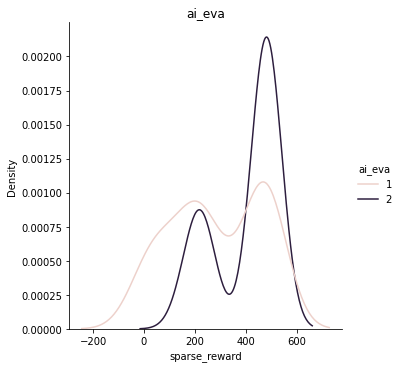

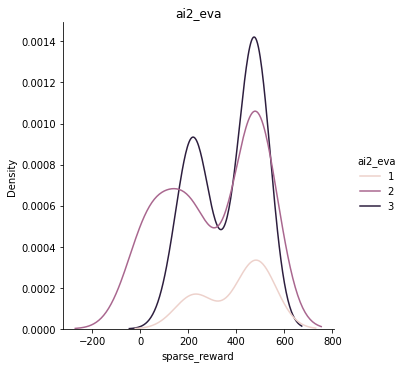

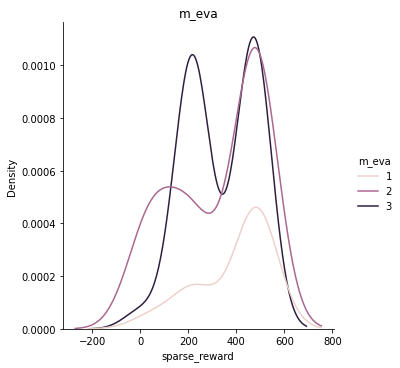

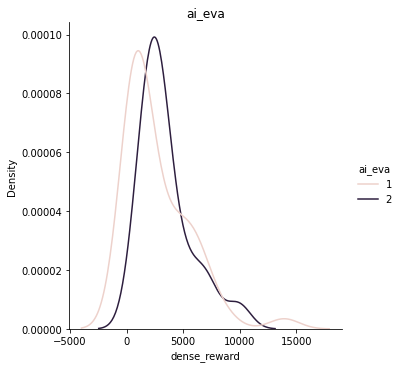

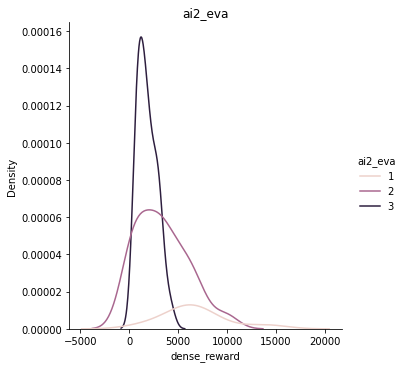

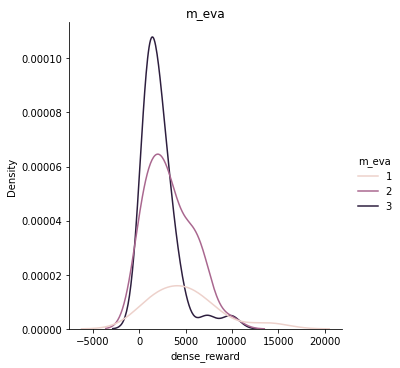

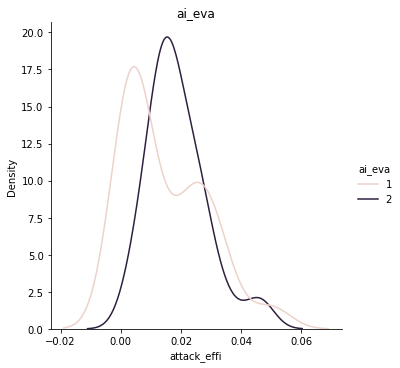

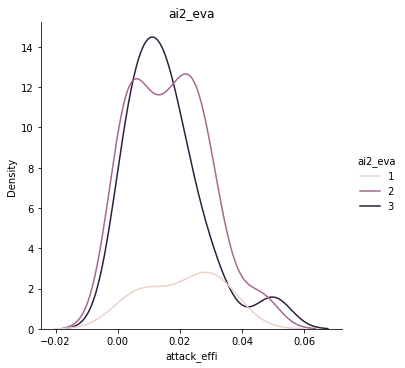

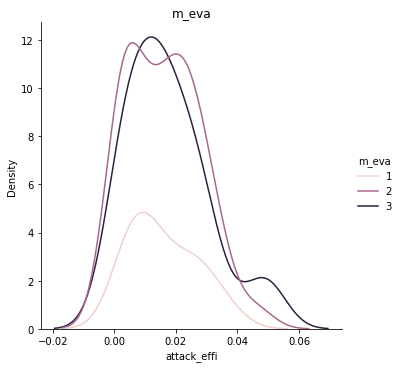

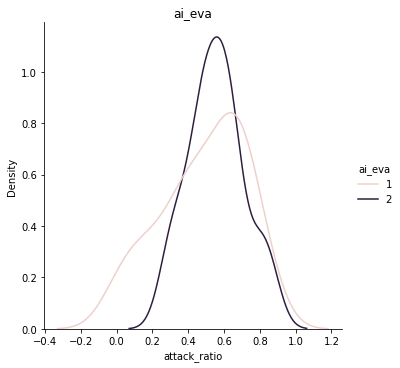

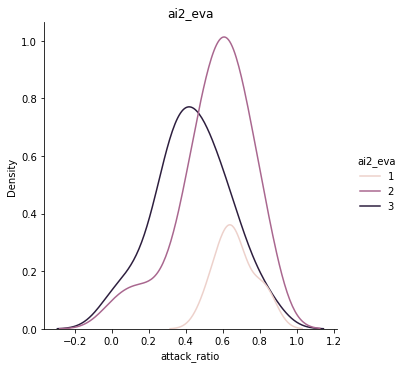

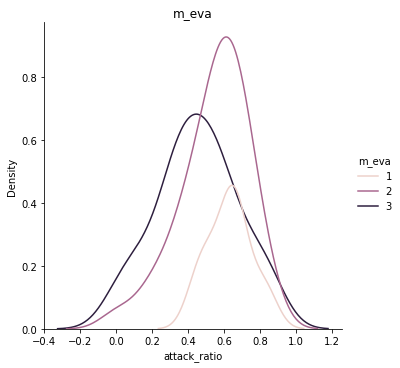

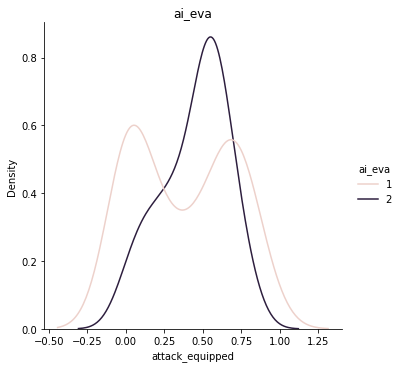

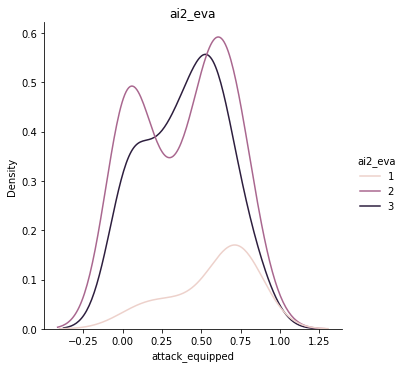

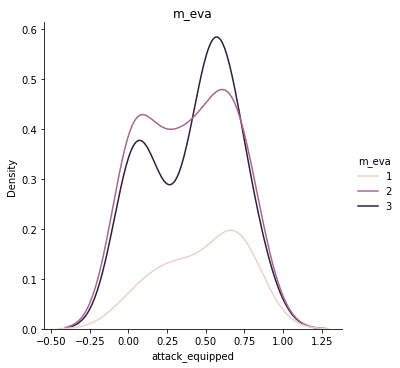

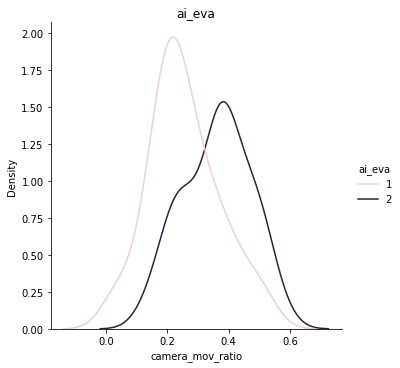

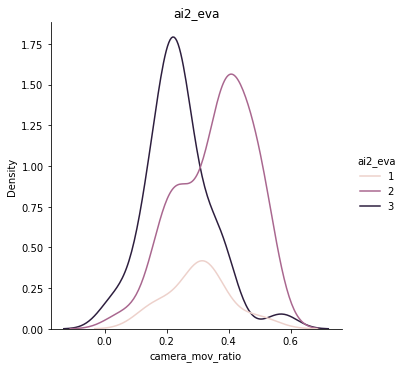

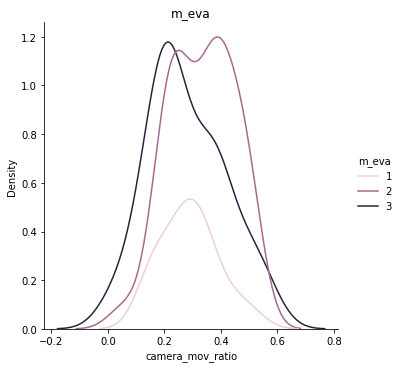

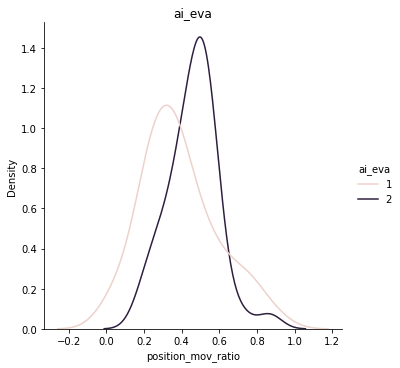

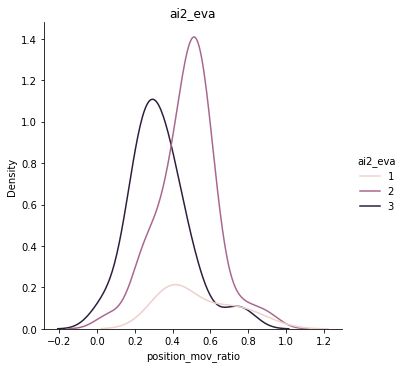

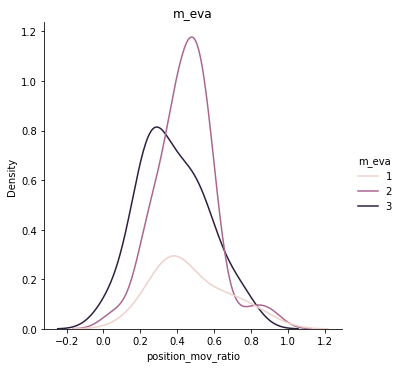

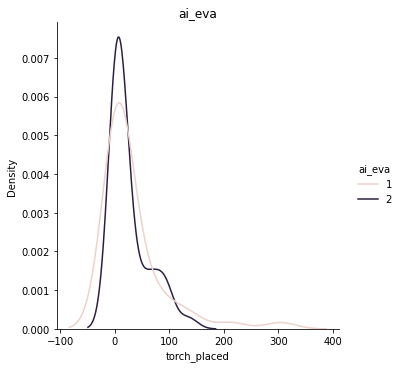

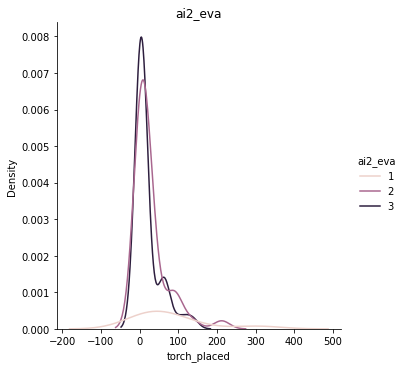

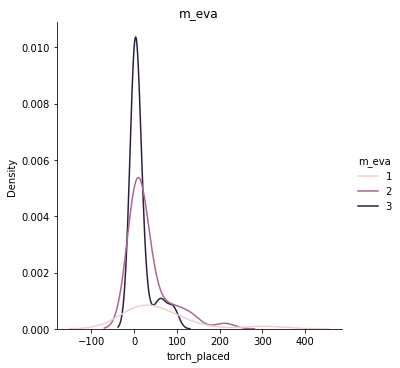

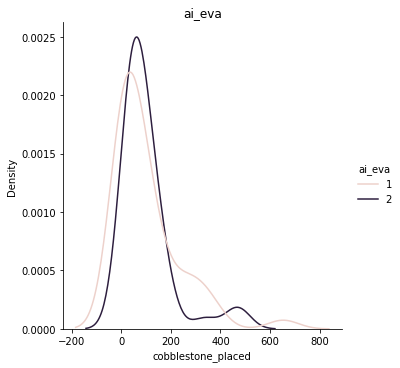

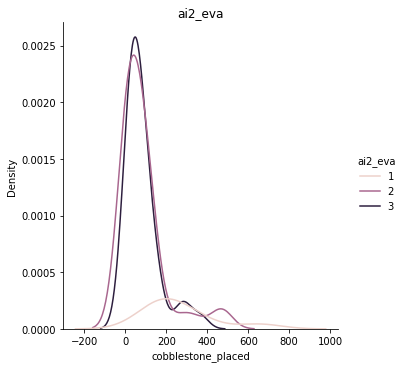

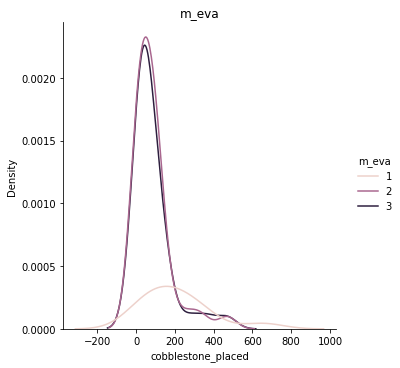

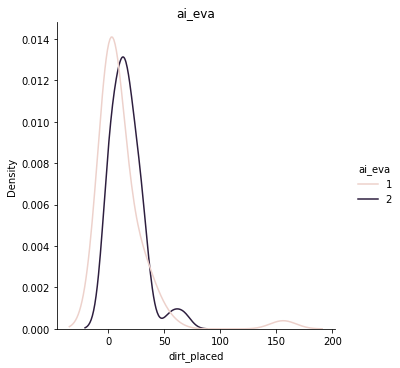

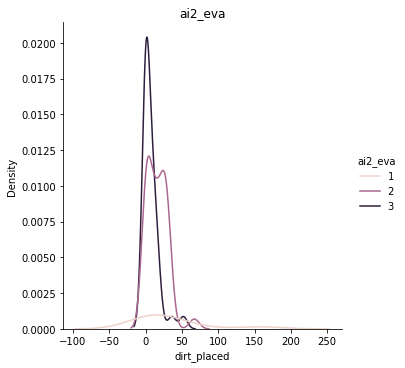

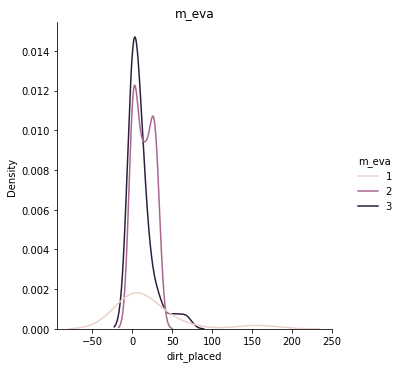

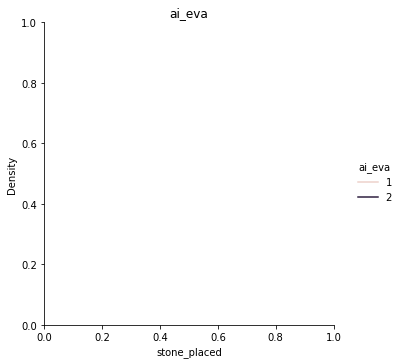

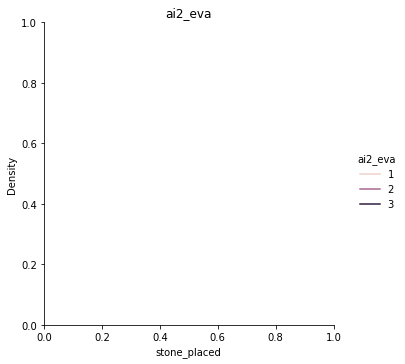

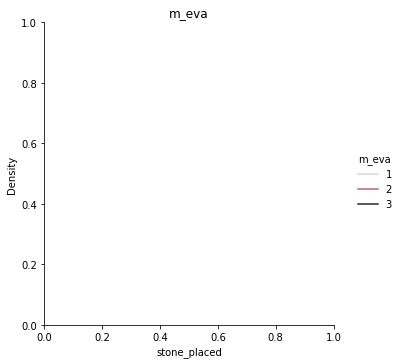

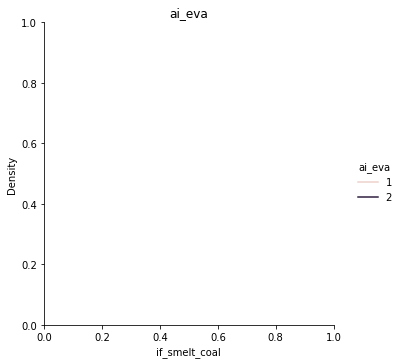

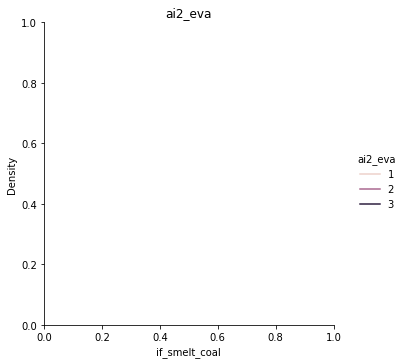

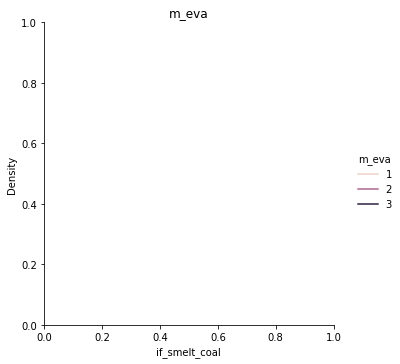

In [52]:
for name in FEATURES_NAME:
    sns.displot(data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
    sns.displot(data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
    sns.displot(data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
#     f=plt.figure()
#     f.add_subplot(1,3,1)
#     sns.displot(data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
#     f.add_subplot(1,3,2)
#     sns.displot(data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
#     f.add_subplot(1,3,3)
#     sns.displot(data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
#     plt.show()
    
    
#     fig, axes = plt.subplots(1, 3)#, figsize=(15, 5), sharey=True
# #     fig.suptitle('Initial Pokemon - 1st Generation')
#     sns.displot(ax=axes[0], data=df, x=name, hue="ai_eva", kind="kde").set(title='ai_eva')
# #     axes[0].set_title(bulbasaur.name)
#     sns.displot(ax=axes[1], data=df, x=name, hue="ai2_eva", kind="kde").set(title='ai2_eva')
#     sns.displot(ax=axes[2], data=df, x=name, hue="m_eva", kind="kde").set(title='m_eva')
    
    

    

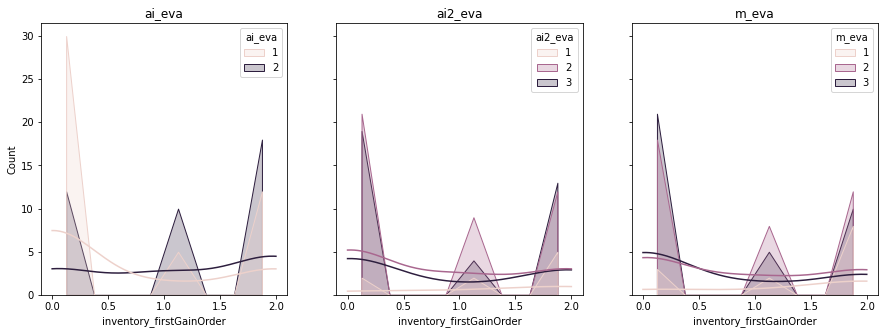

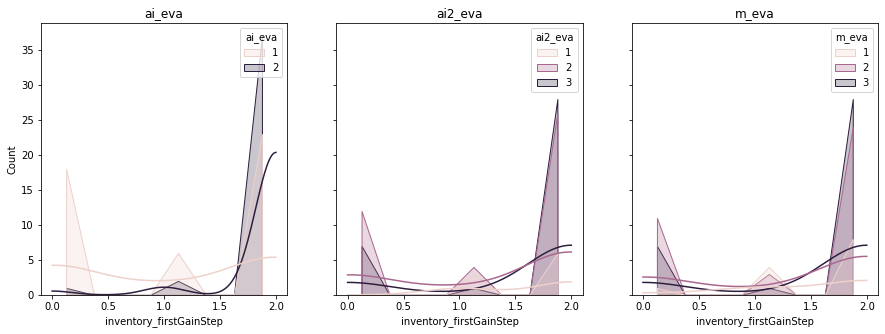

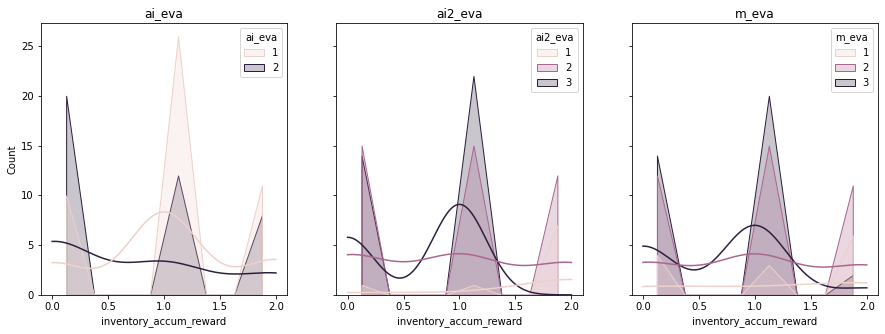

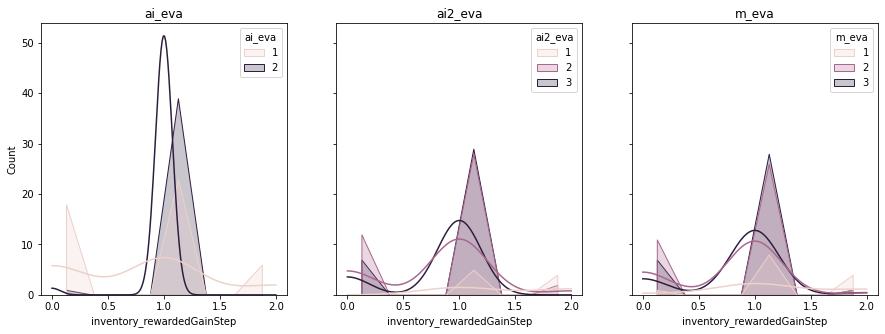

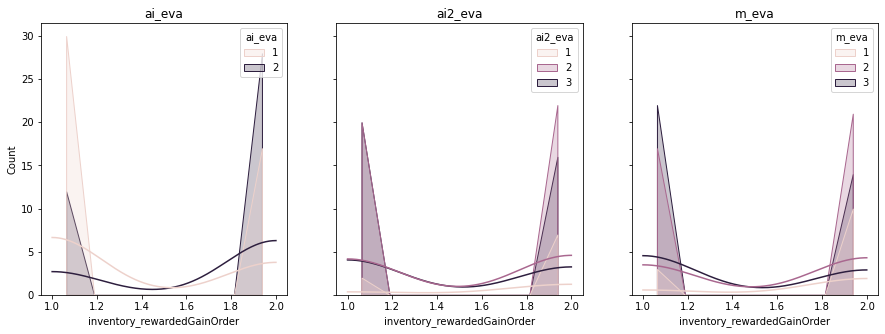

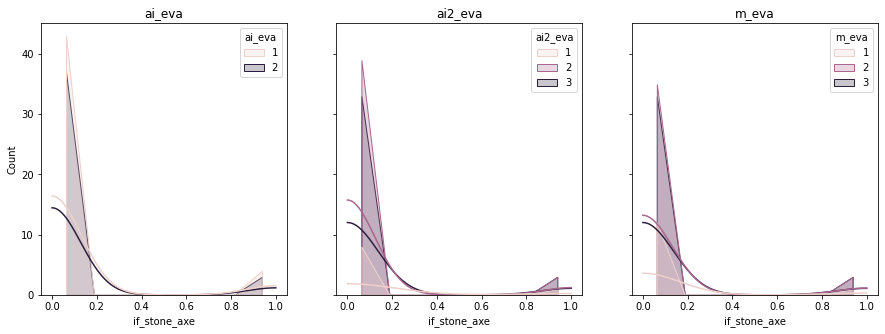

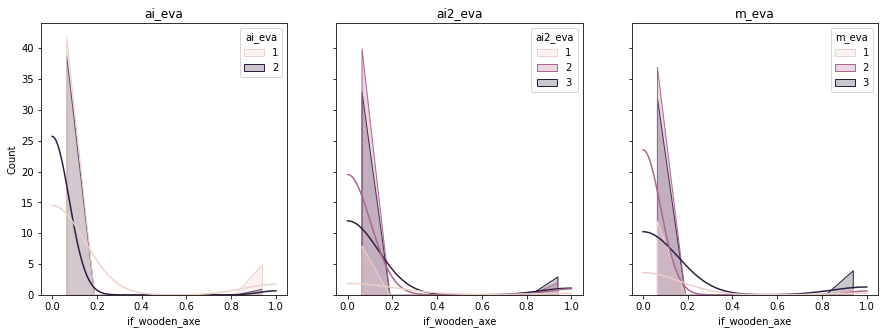

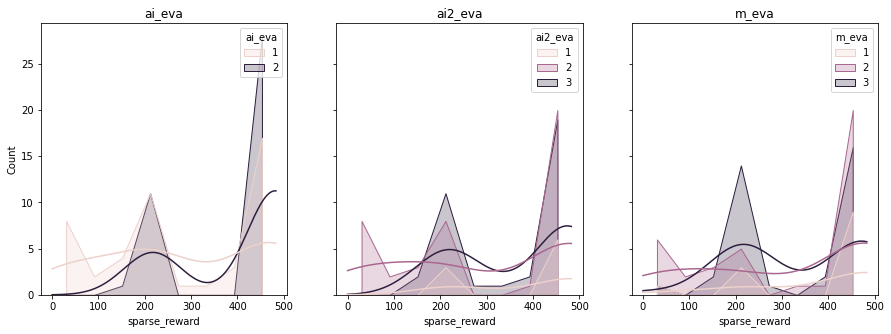

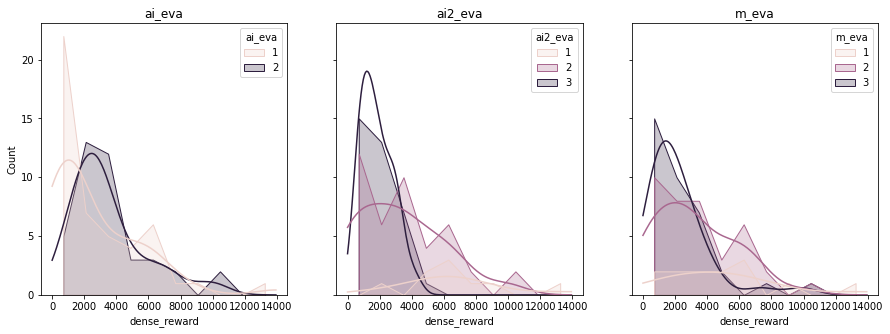

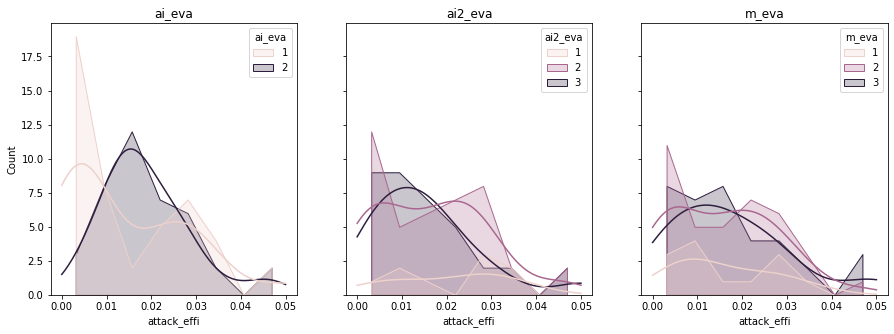

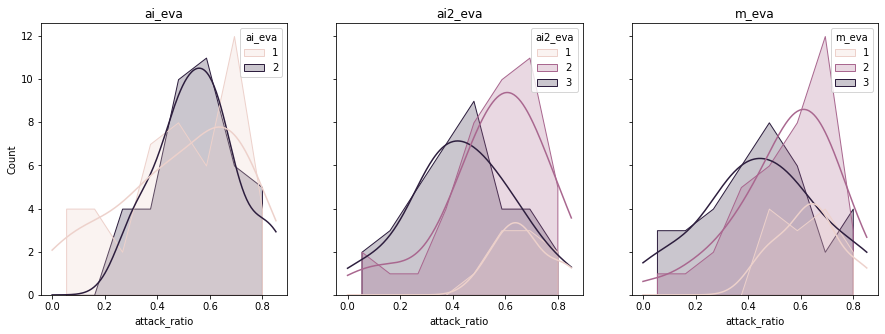

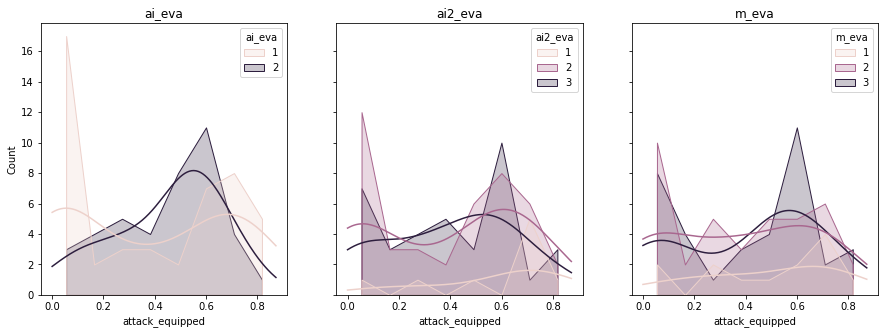

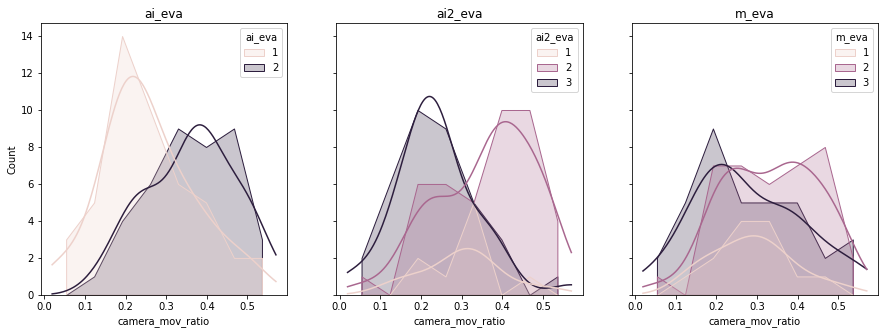

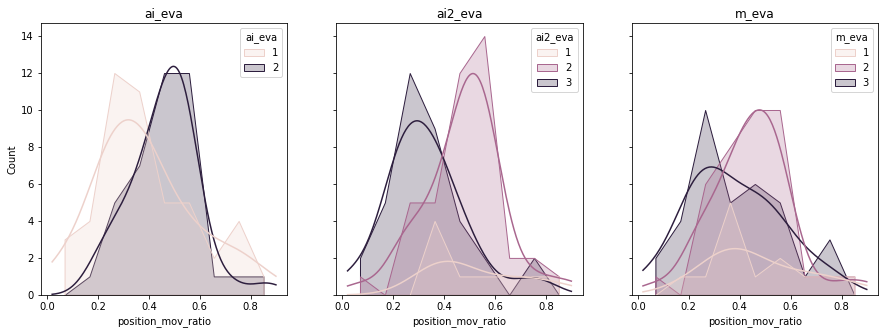

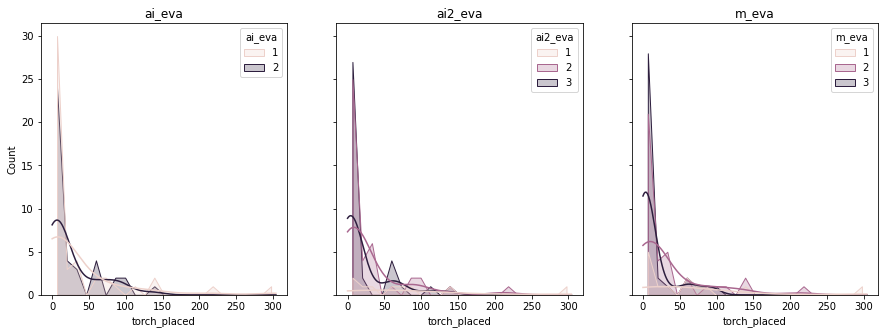

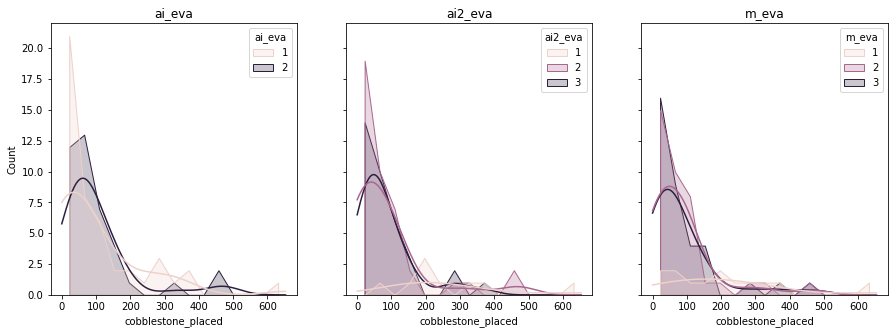

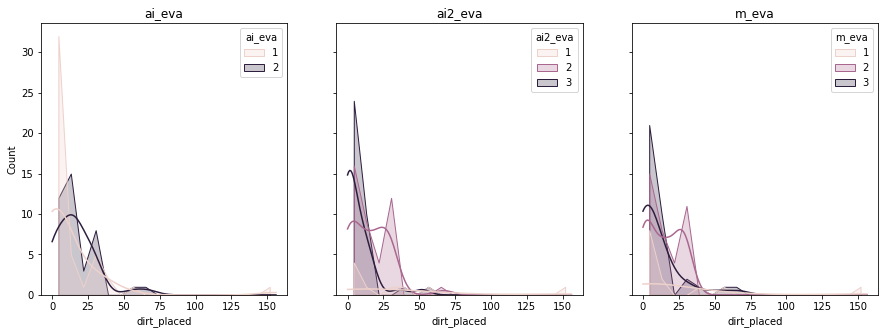

In [53]:
for name in FEATURES_NAME:
    if name=="if_iron_axe" or name=="stone_placed" or name=="if_smelt_coal":
        continue
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
#     fig.suptitle('Initial Pokemon - 1st Generation')
    sns.histplot(ax=axes[0], data=df, x=name, hue="ai_eva", kde=True, element="poly").set(title='ai_eva')
#     axes[0].set_title(bulbasaur.name)
    sns.histplot(ax=axes[1], data=df, x=name, hue="ai2_eva", kde=True, element="poly").set(title='ai2_eva')
    sns.histplot(ax=axes[2], data=df, x=name, hue="m_eva", kde=True, element="poly").set(title='m_eva')

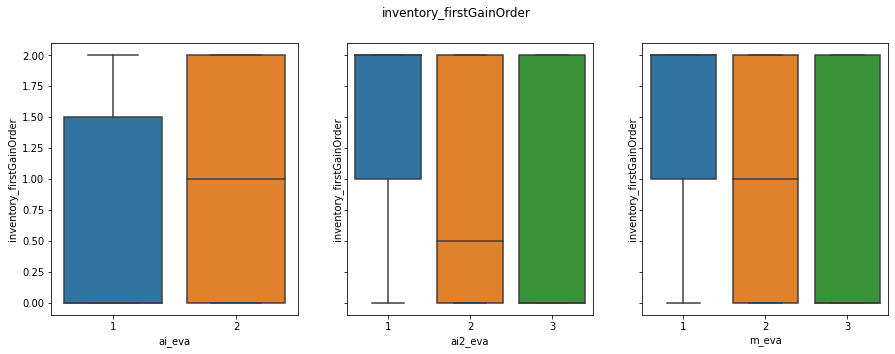

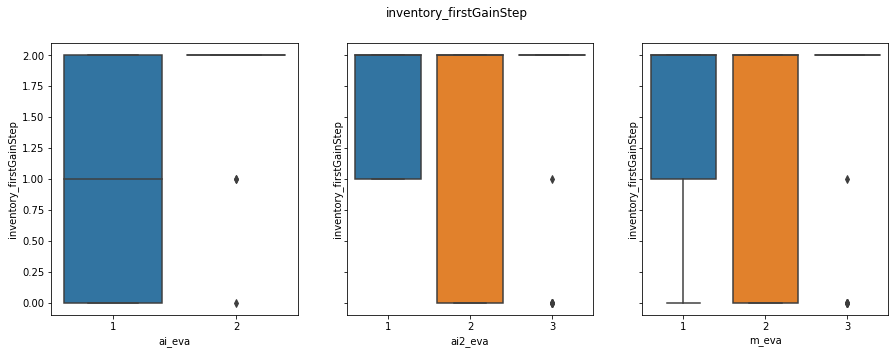

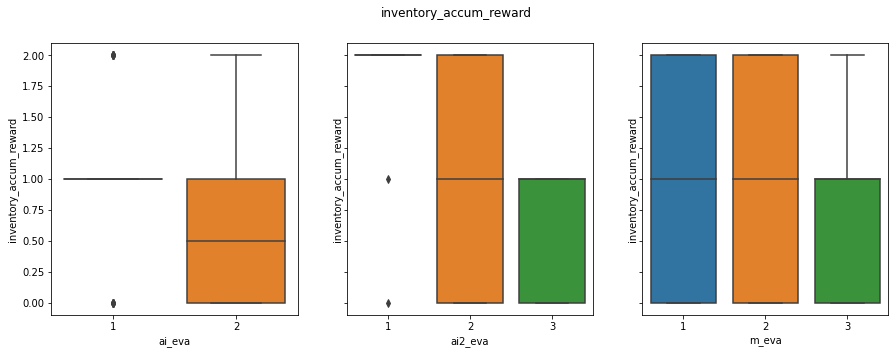

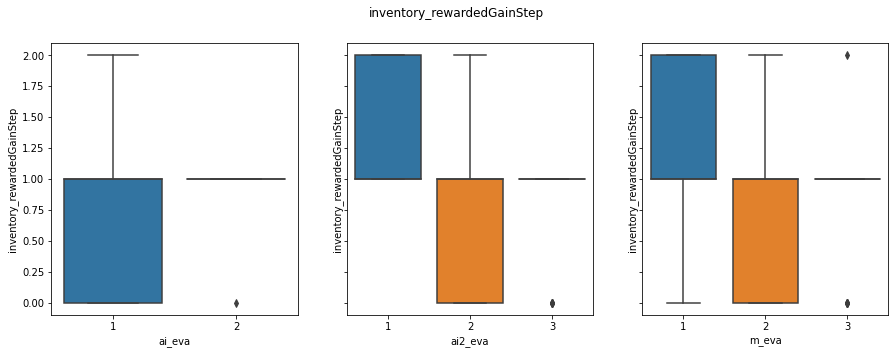

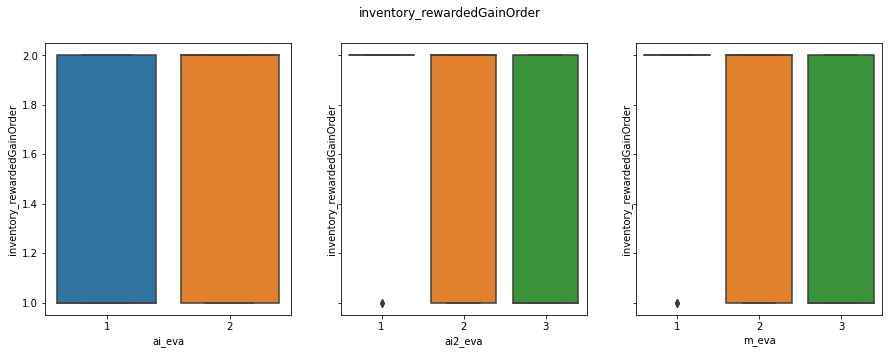

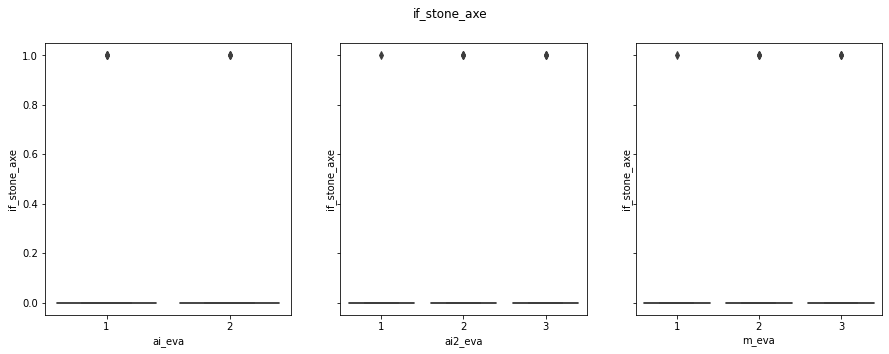

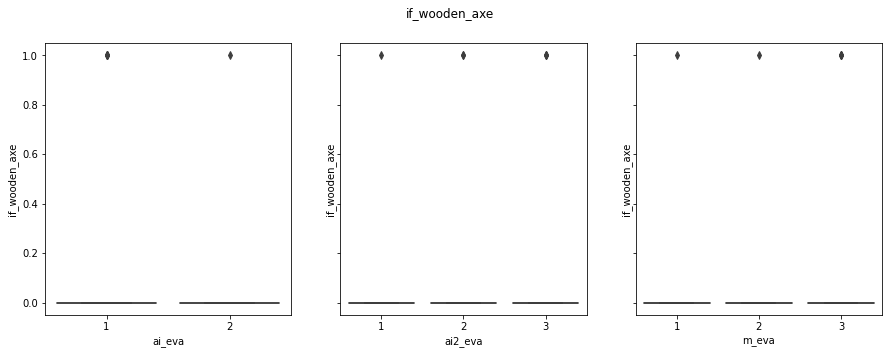

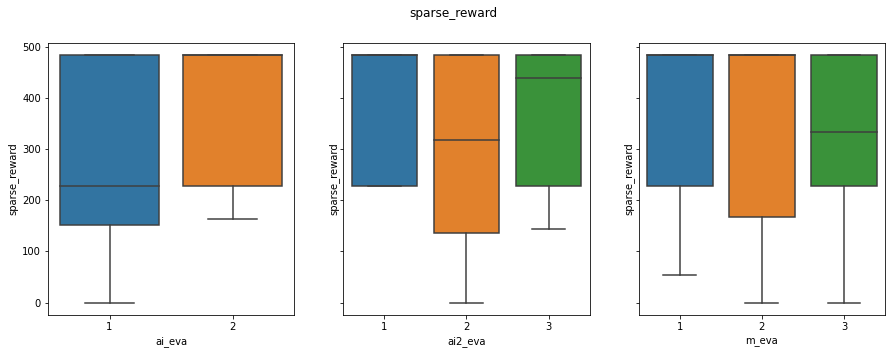

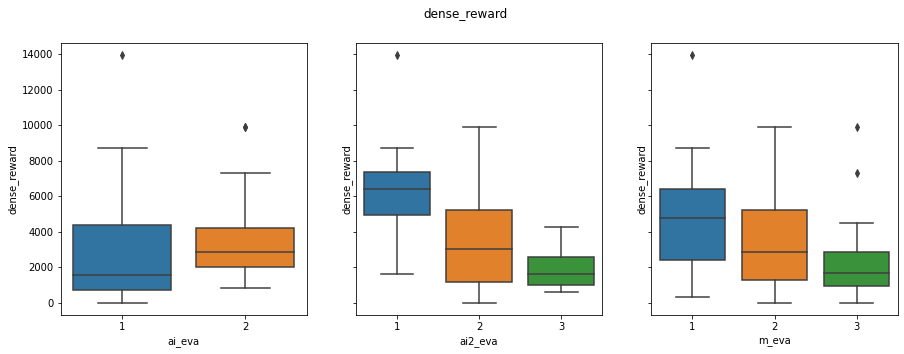

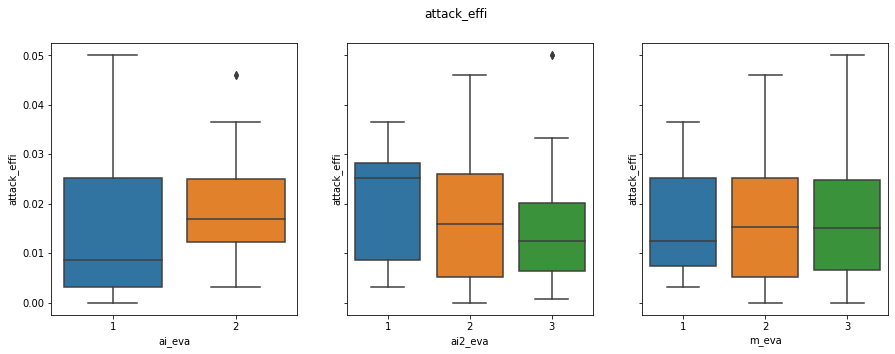

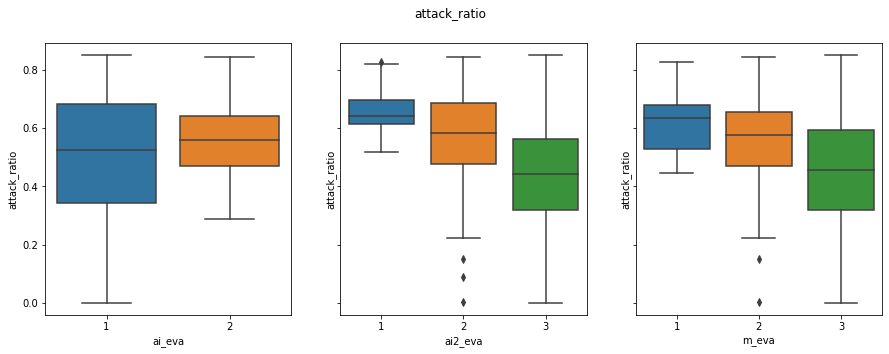

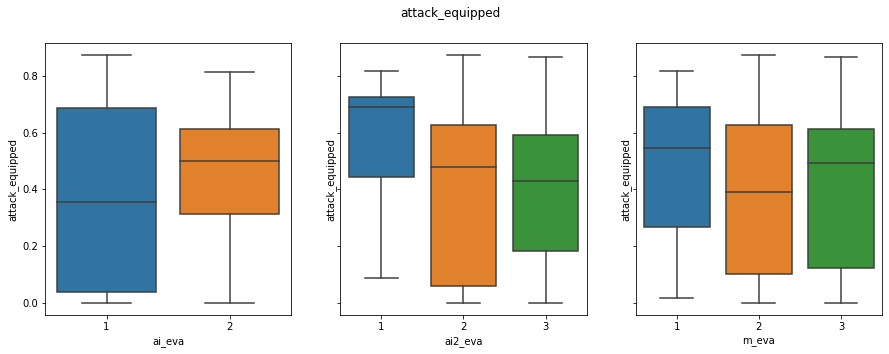

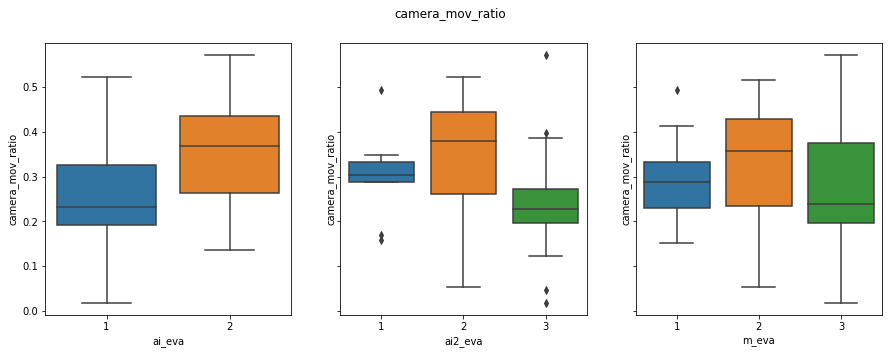

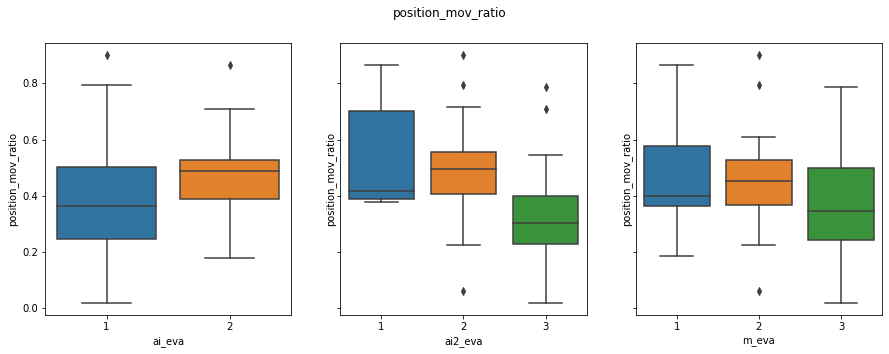

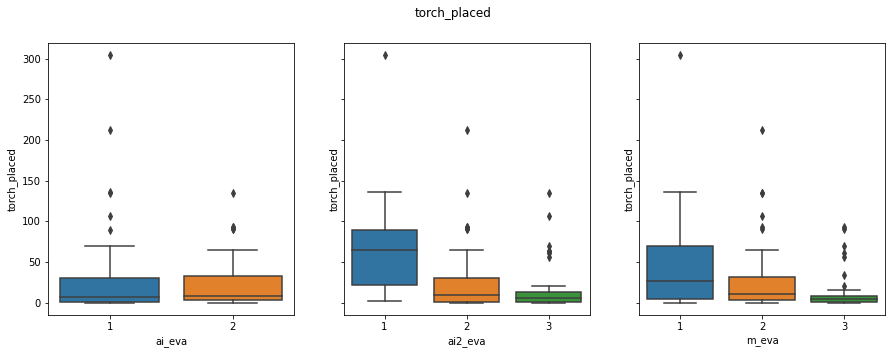

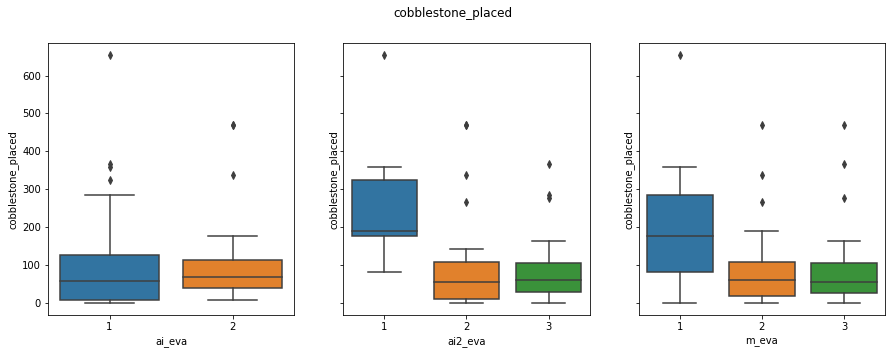

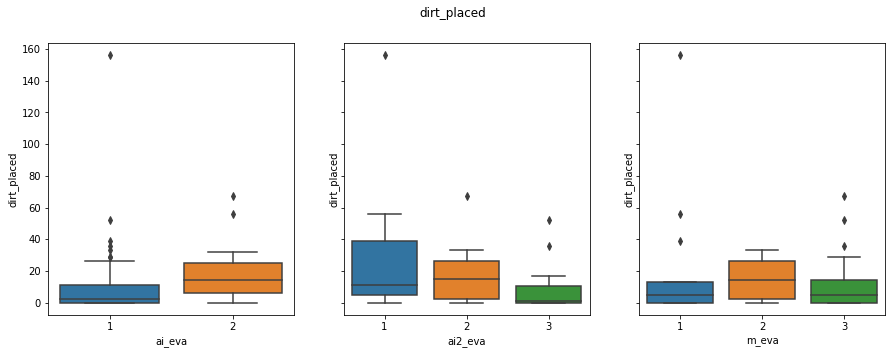

In [55]:
for name in FEATURES_NAME:
    if name=="if_iron_axe" or name=="stone_placed" or name=="if_smelt_coal":
        continue
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(name)
    sns.boxplot(ax=axes[0], data=df, y=name, x="ai_eva")
#     axes[0].set_title(bulbasaur.name)
    sns.boxplot(ax=axes[1], data=df, y=name, x="ai2_eva")
    sns.boxplot(ax=axes[2], data=df, y=name, x="m_eva")

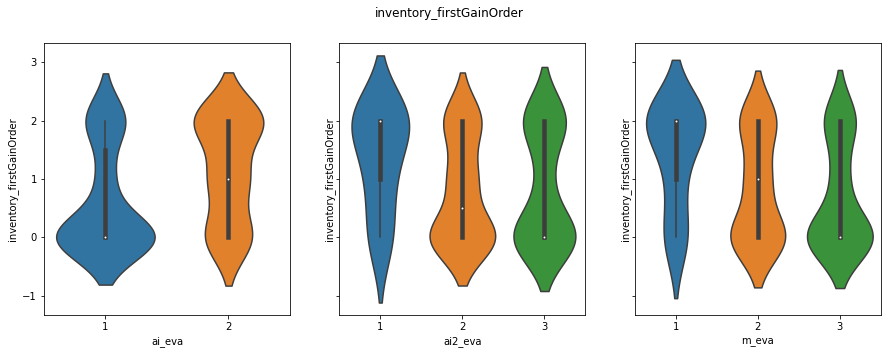

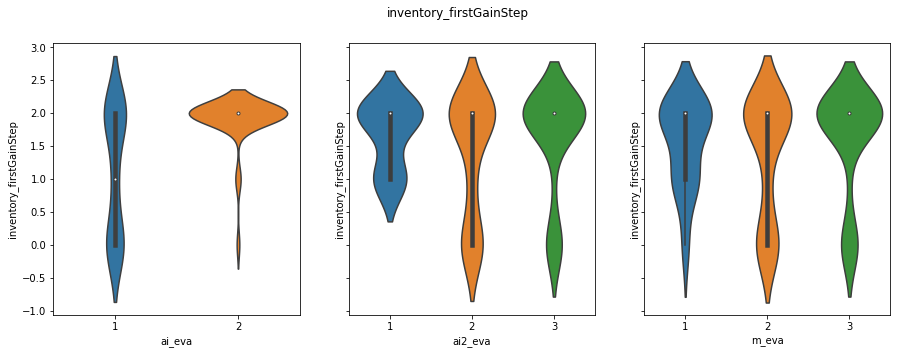

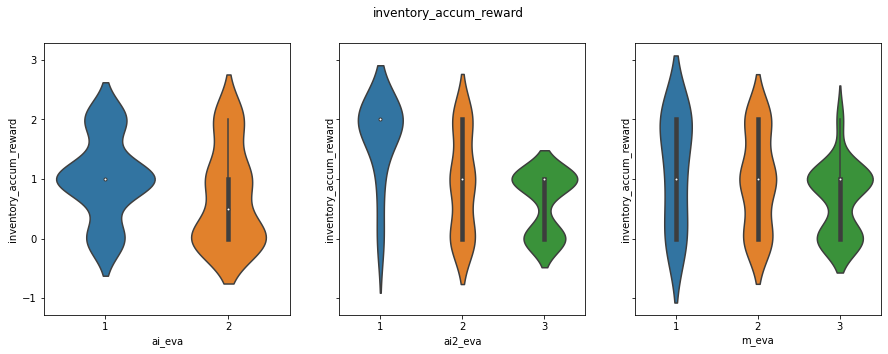

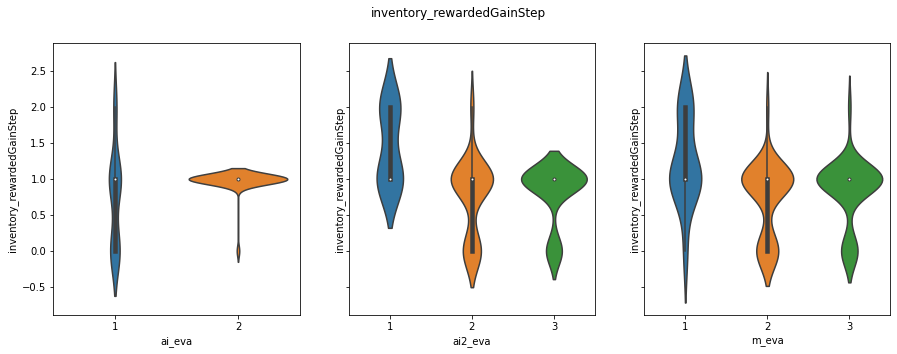

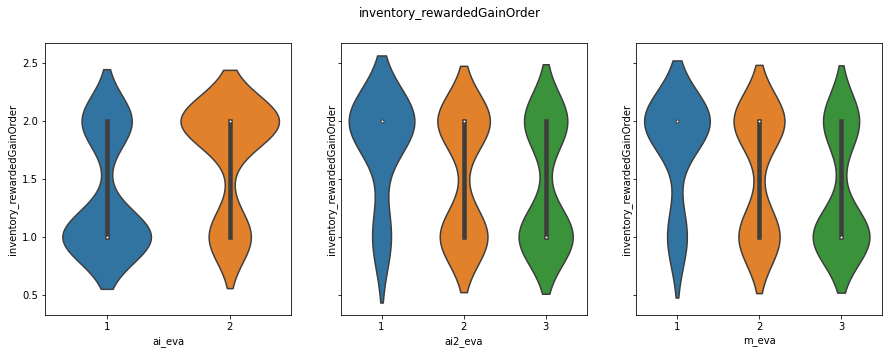

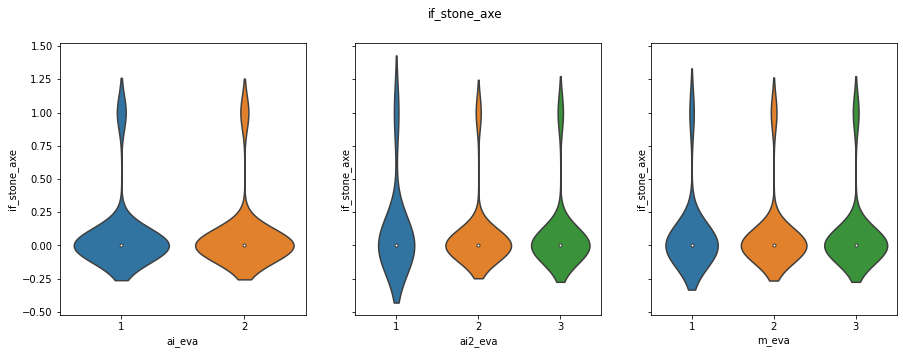

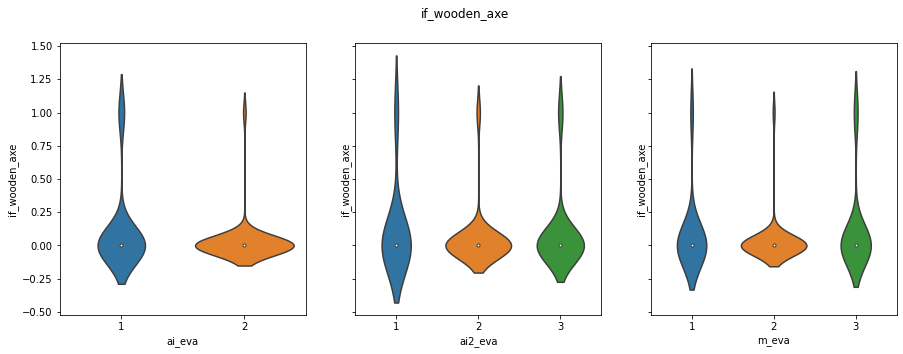

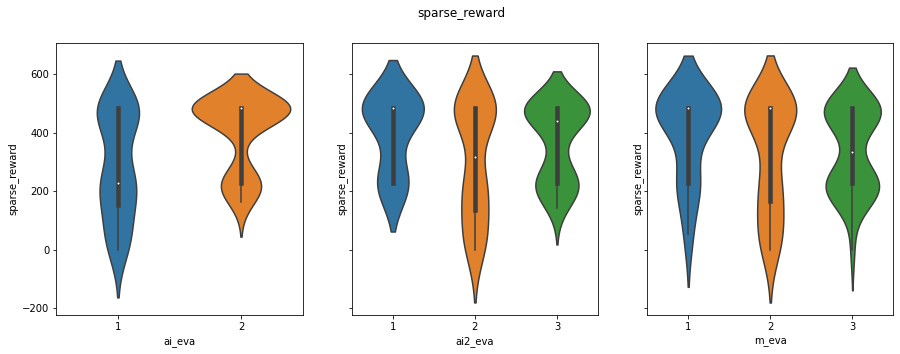

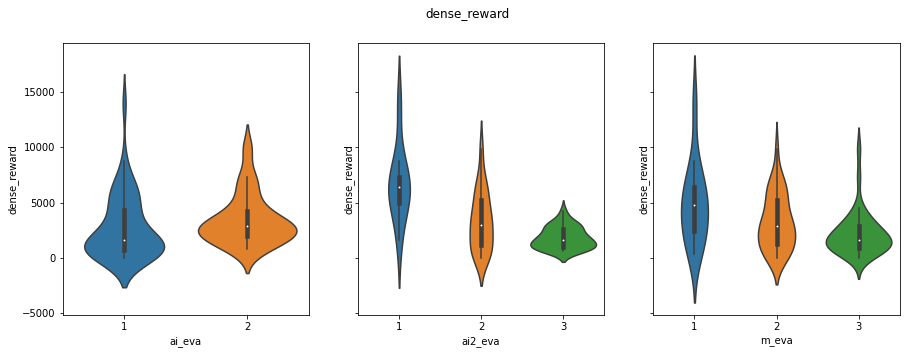

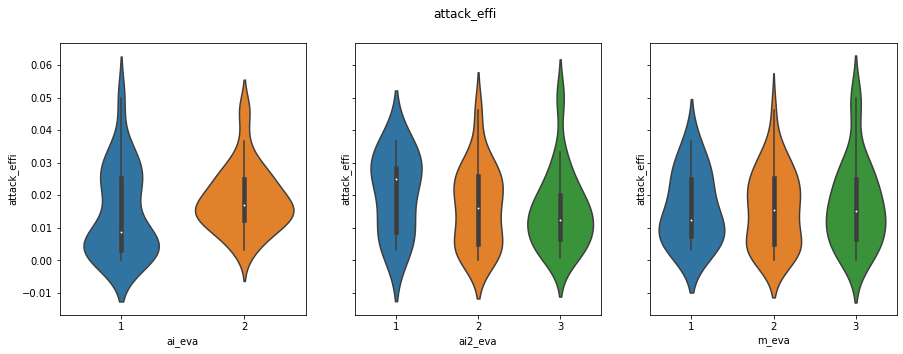

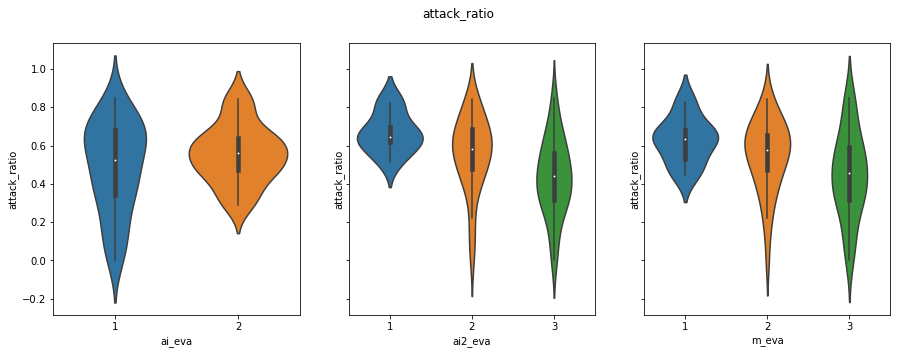

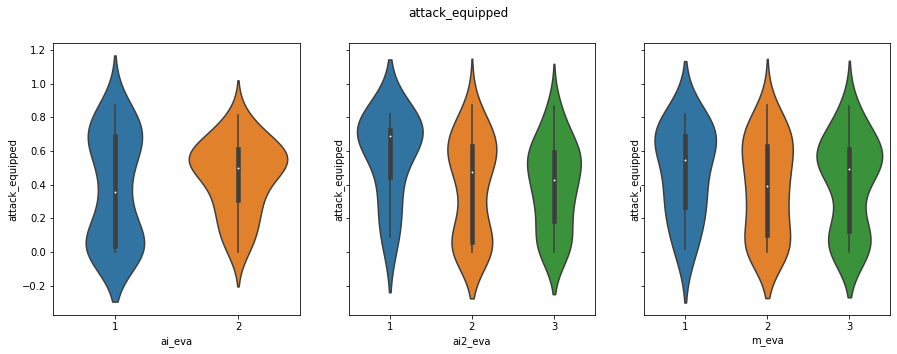

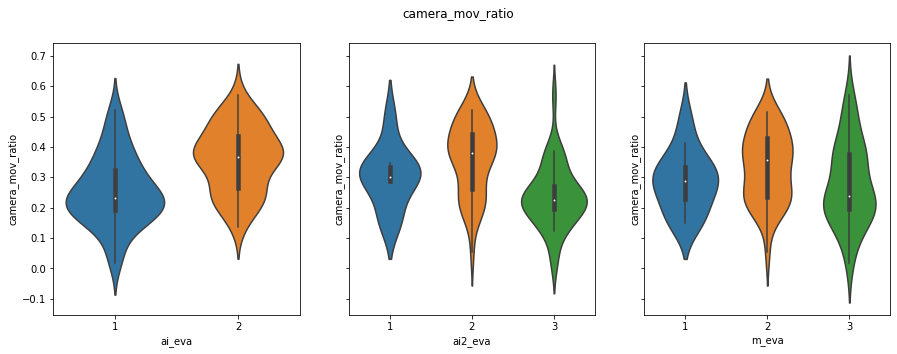

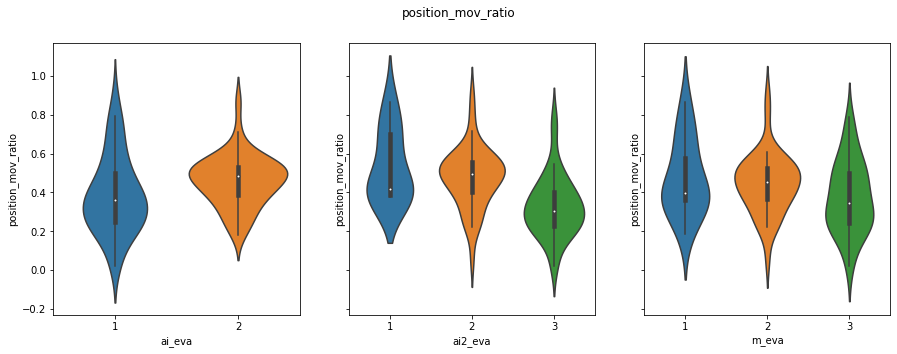

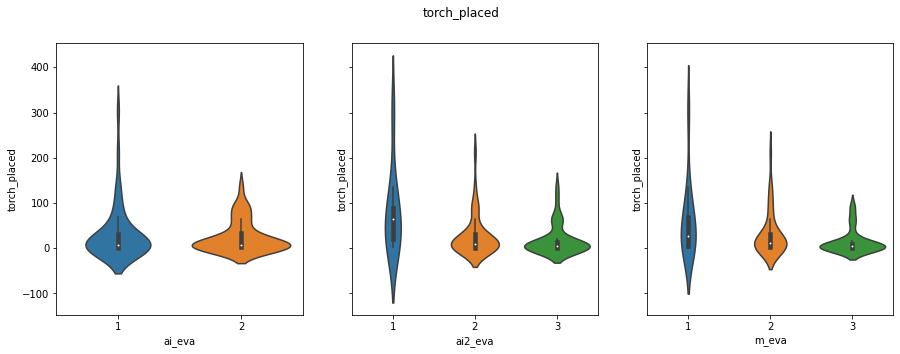

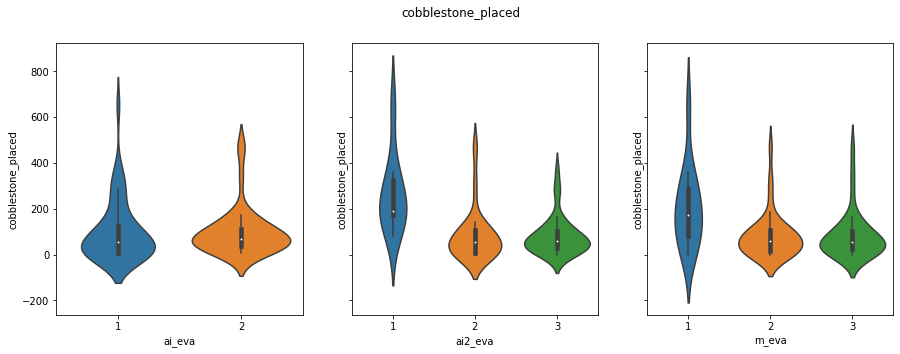

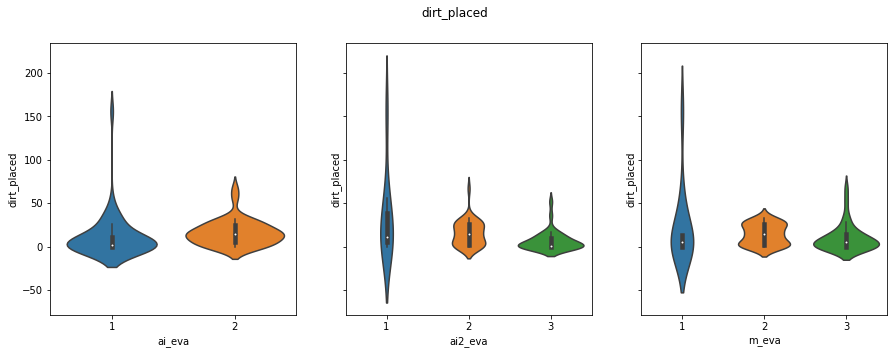

In [56]:

for name in FEATURES_NAME:
    if name=="if_iron_axe" or name=="stone_placed" or name=="if_smelt_coal":
        continue
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(name)
    sns.violinplot(ax=axes[0], data=df, y=name, x="ai_eva")
#     axes[0].set_title(bulbasaur.name)
    sns.violinplot(ax=axes[1], data=df, y=name, x="ai2_eva")
    sns.violinplot(ax=axes[2], data=df, y=name, x="m_eva")

In [ ]:
# m_eva=3,ai_eva=1
#31
# m_eva=1,ai_eva=2
#12


# m_eva=3, ai2_eva=1&2
32
# m_eva=1, ai2_eva=3
13

In [59]:
# df.insert(df.shape[1], "m_ai1", df["m_eva"]+df["ai_eva"])
# df.insert(df.shape[1], "m_ai2", df["m_eva"]+df["ai2_eva"])
df["m_ai1"]=df["m_eva"].map(str)+df["ai_eva"].map(str)
df["m_ai2"]=df["m_eva"].map(str)+df["ai2_eva"].map(str)
df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)

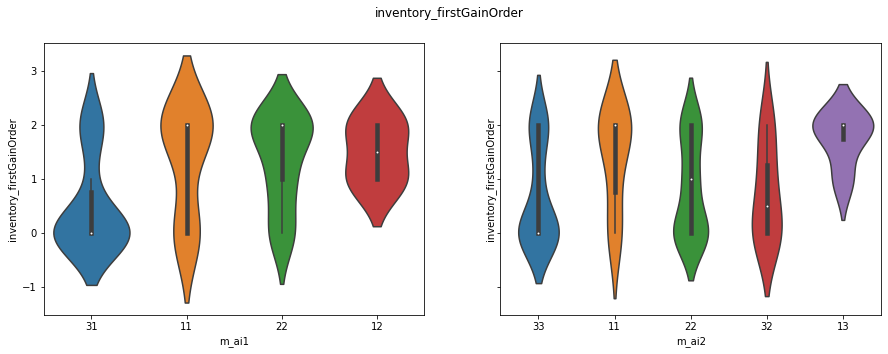

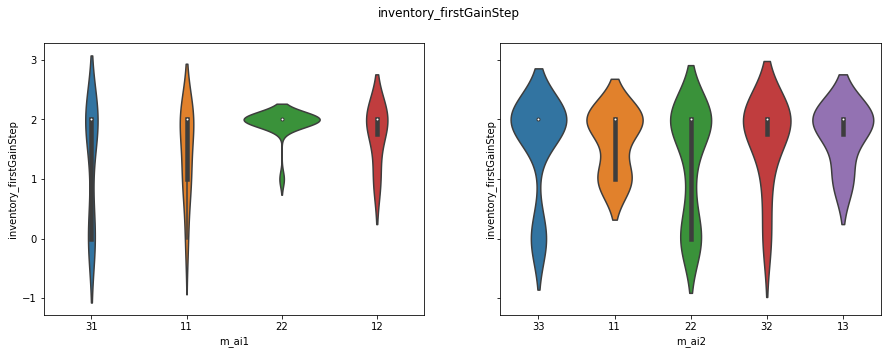

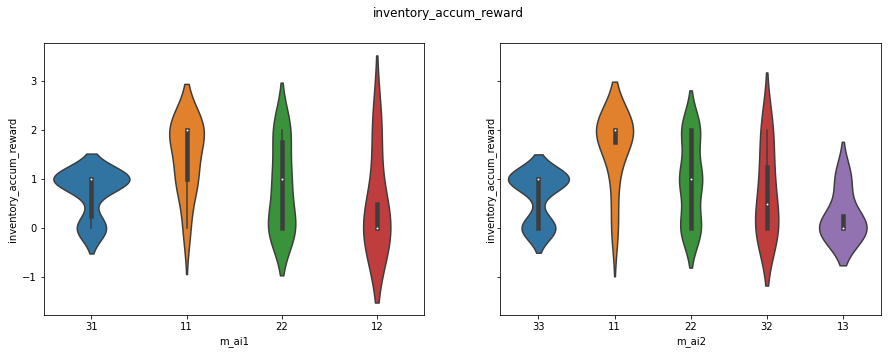

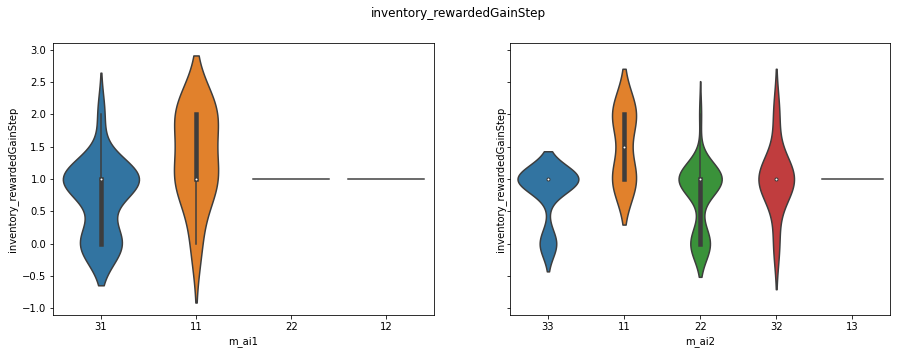

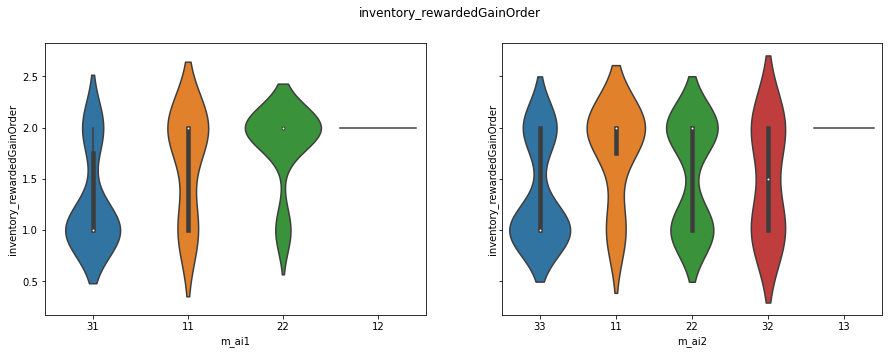

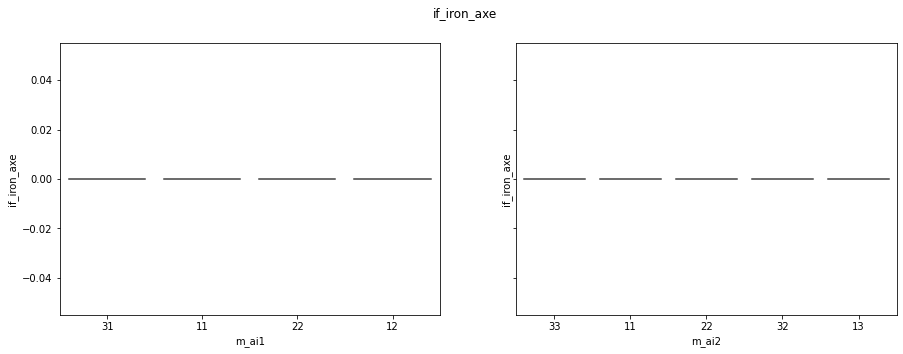

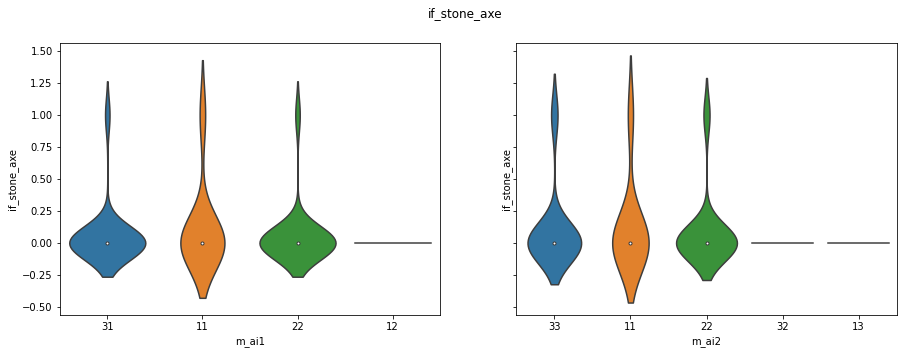

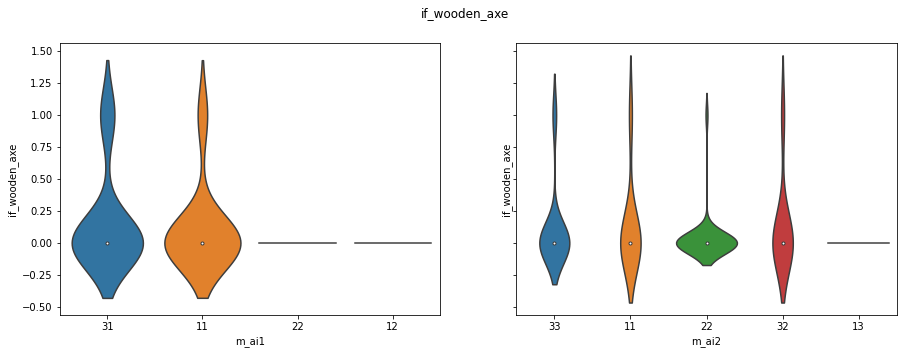

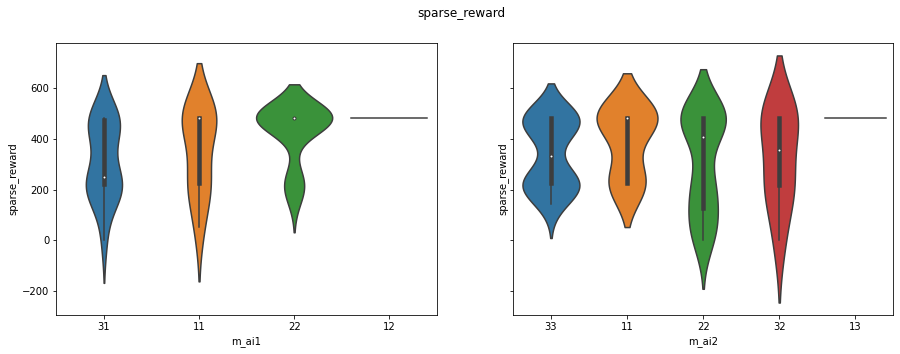

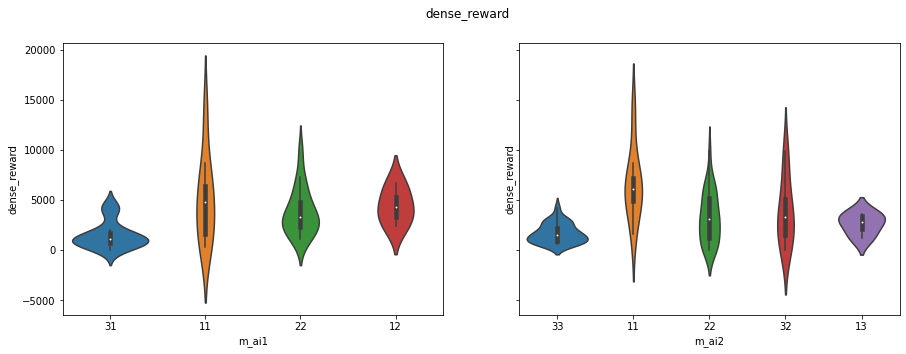

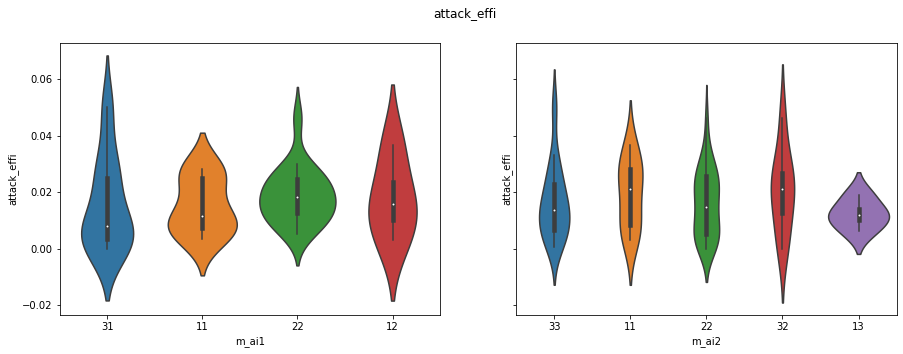

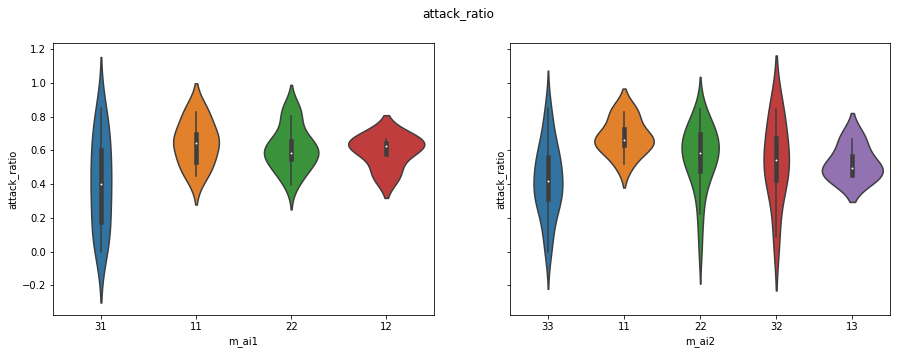

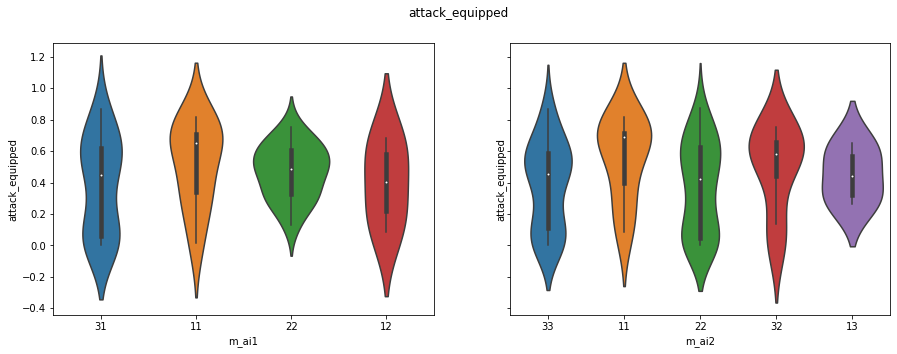

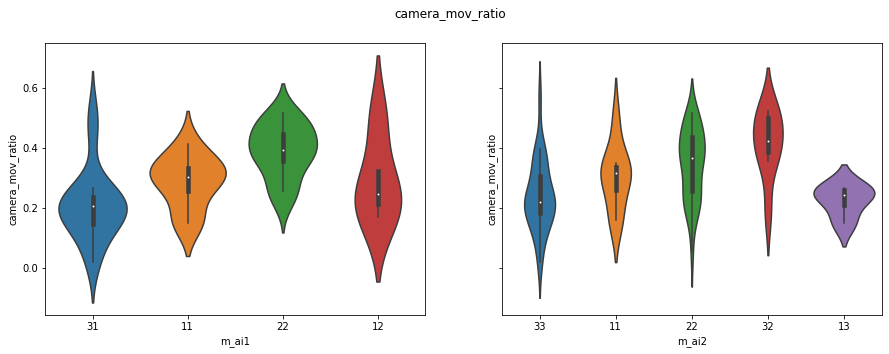

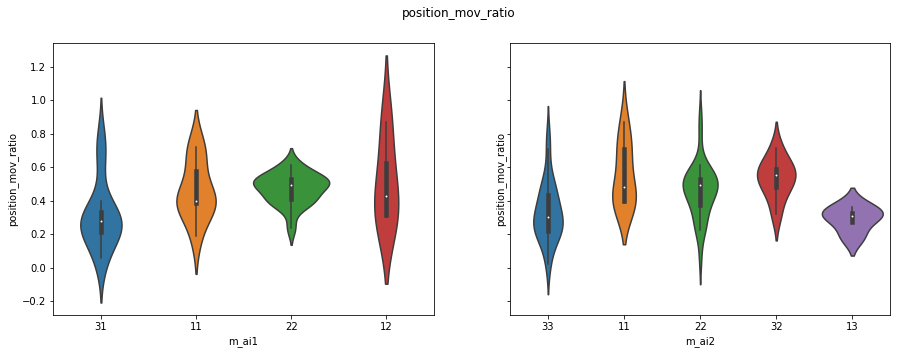

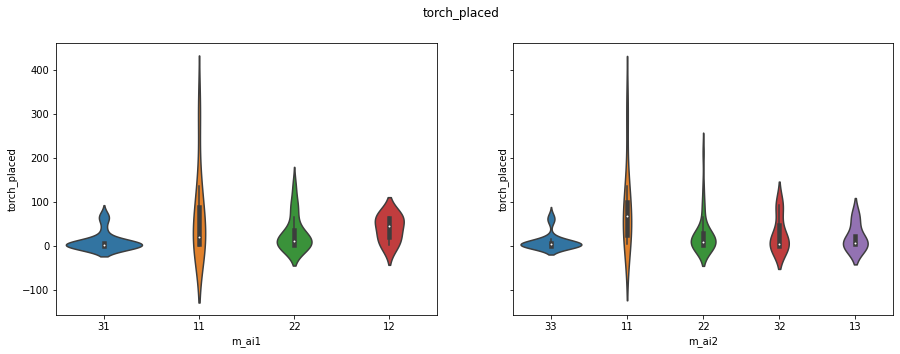

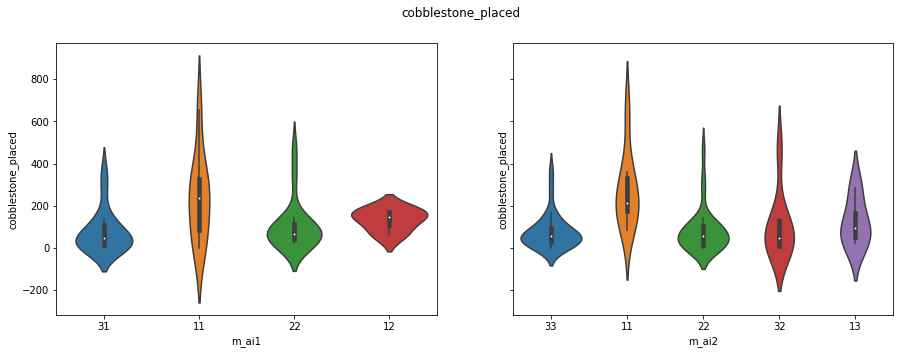

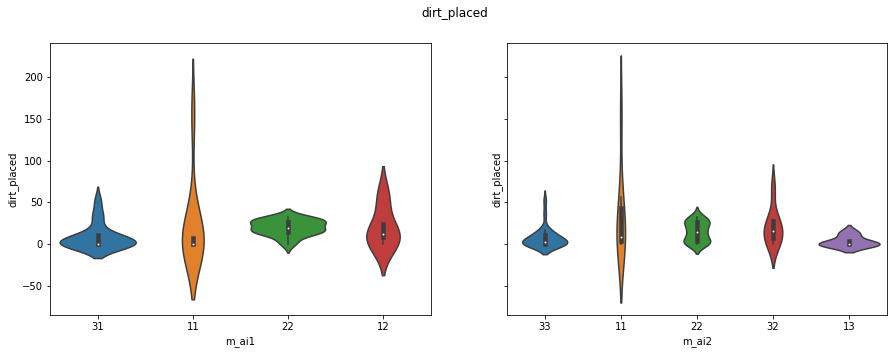

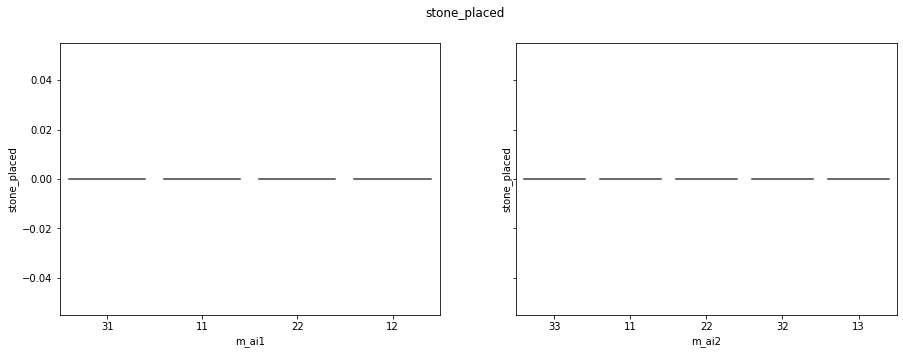

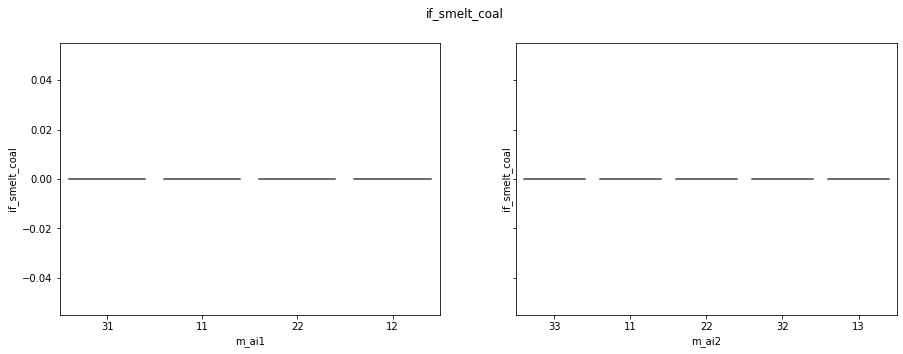

In [66]:
df1=df[df['m_ai1'].isin(["31","12","11","22"])]
df2=df[df['m_ai2'].isin(["32","13","11","22","33"])]
for name in FEATURES_NAME:
#     if name=="if_iron_axe" or name=="stone_placed" or name=="if_smelt_coal":
#         continue
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle(name)
    sns.violinplot(ax=axes[0],data=df1, y=name, x="m_ai1")
#     axes[0].set_title(bulbasaur.name)
    sns.violinplot(ax=axes[1],data=df2, y=name, x="m_ai2")

In [67]:
df["m_ai1_2"]=df["m_eva"].map(str)+df["ai_eva"].map(str)+df["ai2_eva"].map(str)
df.to_csv("./test-data/fea_m_all_ai2.csv", encoding="utf_8_sig", index=False)

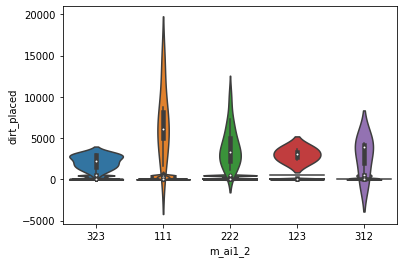

In [74]:
df3=df[df['m_ai1_2'].isin(["312","123","111","222","323"])]
for name in FEATURES_NAME:
    if name=="if_iron_axe" or name=="stone_placed" or name=="if_smelt_coal":
        continue
    sns.violinplot(data=df3, y=name, x="m_ai1_2")
    

<AxesSubplot:xlabel='m_ai1_2', ylabel='camera_mov_ratio'>

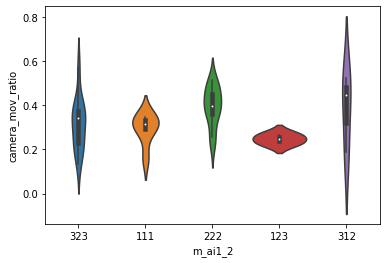

In [75]:
sns.violinplot(data=df3, y="camera_mov_ratio", x="m_ai1_2")